Processing points:   0%|          | 0/4 [00:00<?, ?it/s]

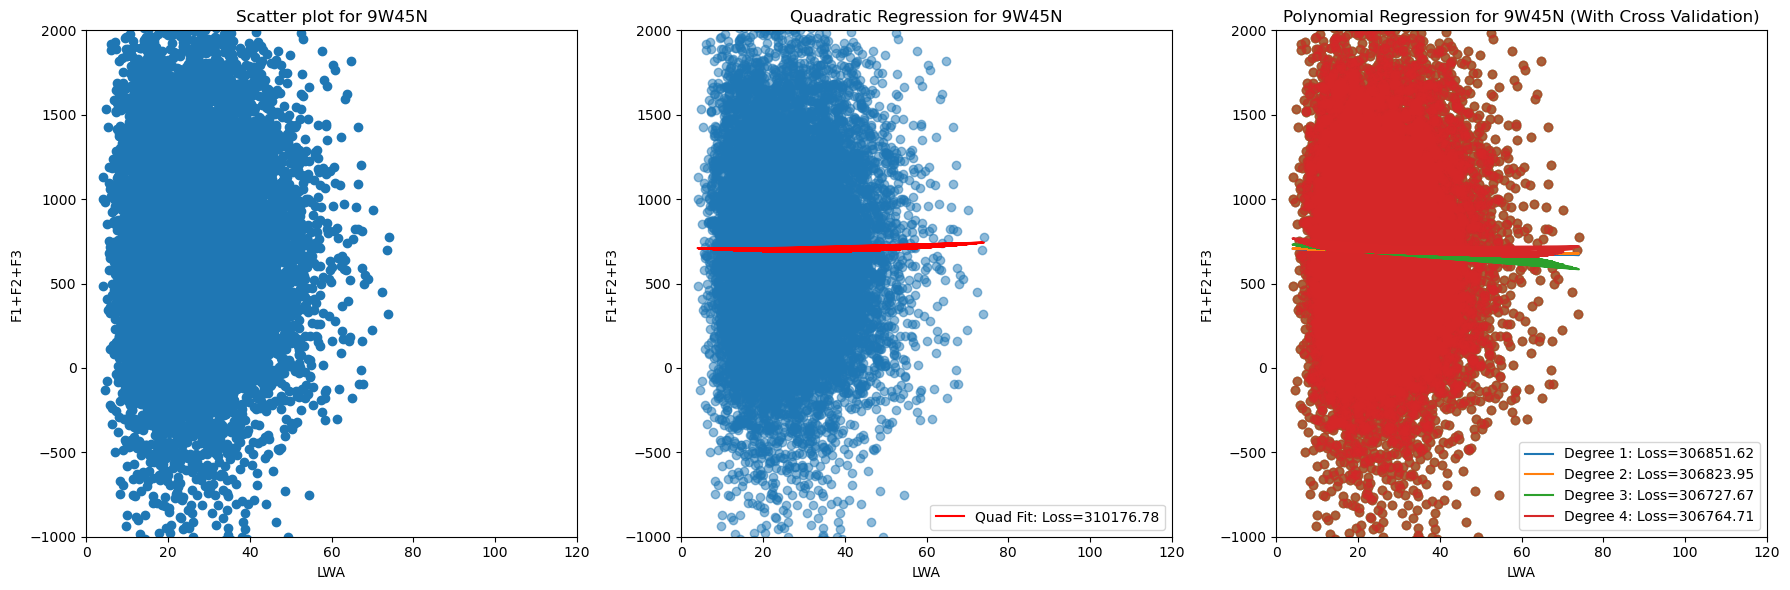

Processing points:  25%|██▌       | 1/4 [00:02<00:06,  2.02s/it]

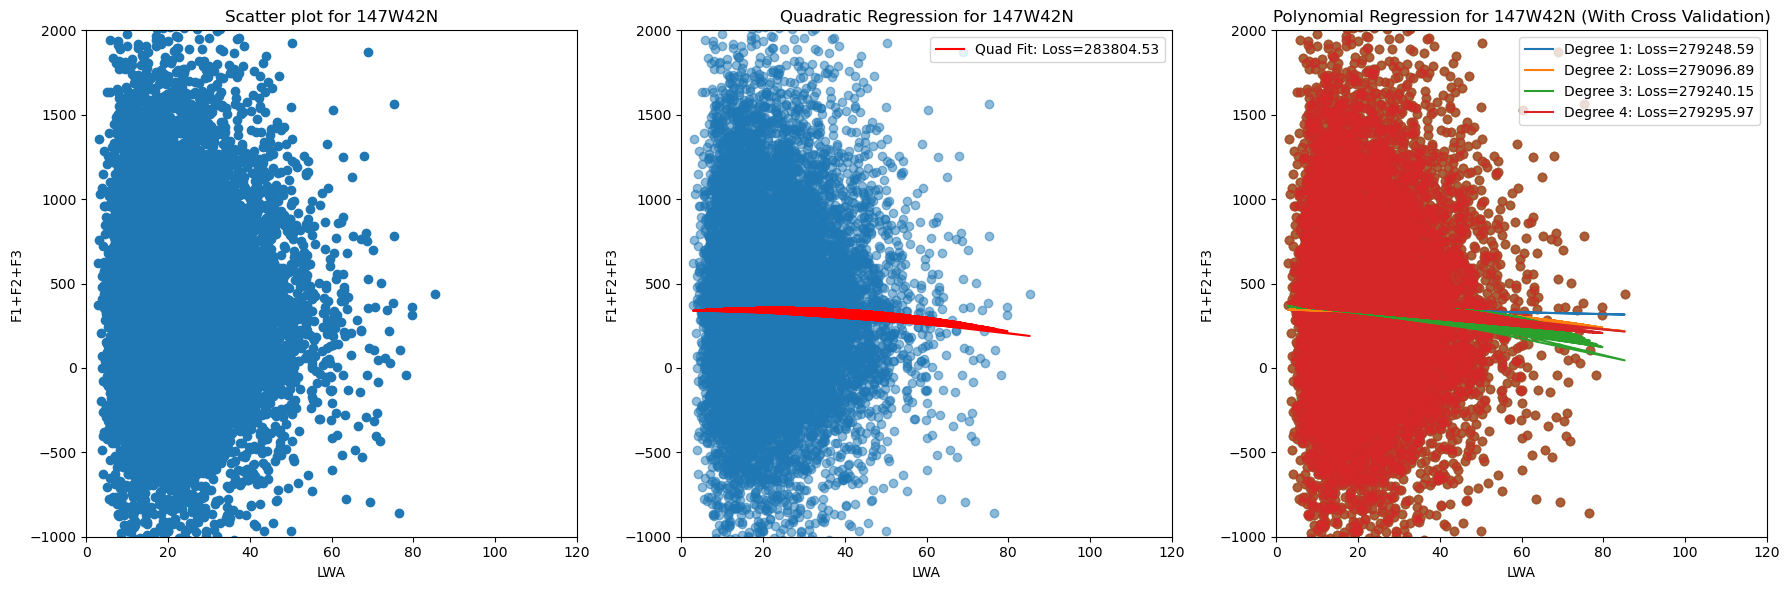

Processing points:  50%|█████     | 2/4 [00:04<00:04,  2.49s/it]

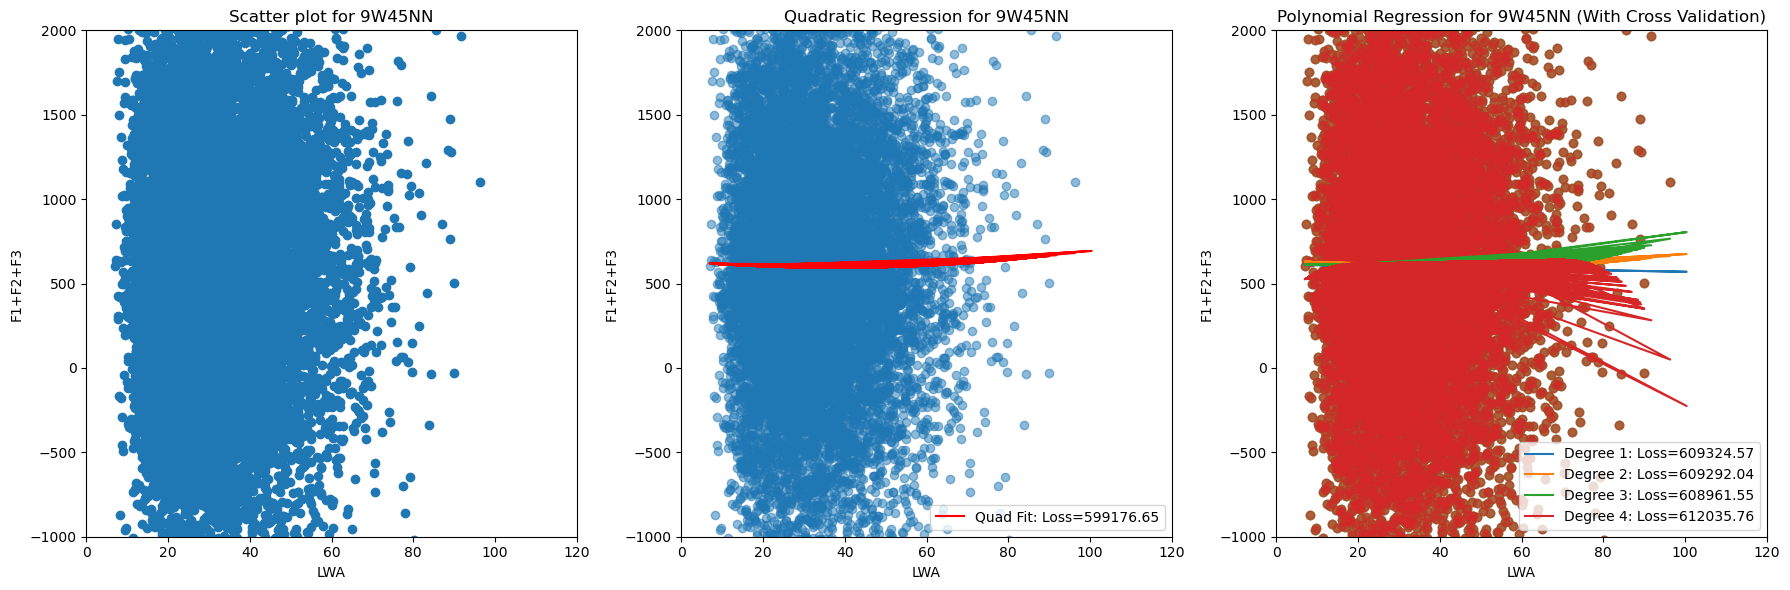

Processing points:  75%|███████▌  | 3/4 [00:07<00:02,  2.70s/it]

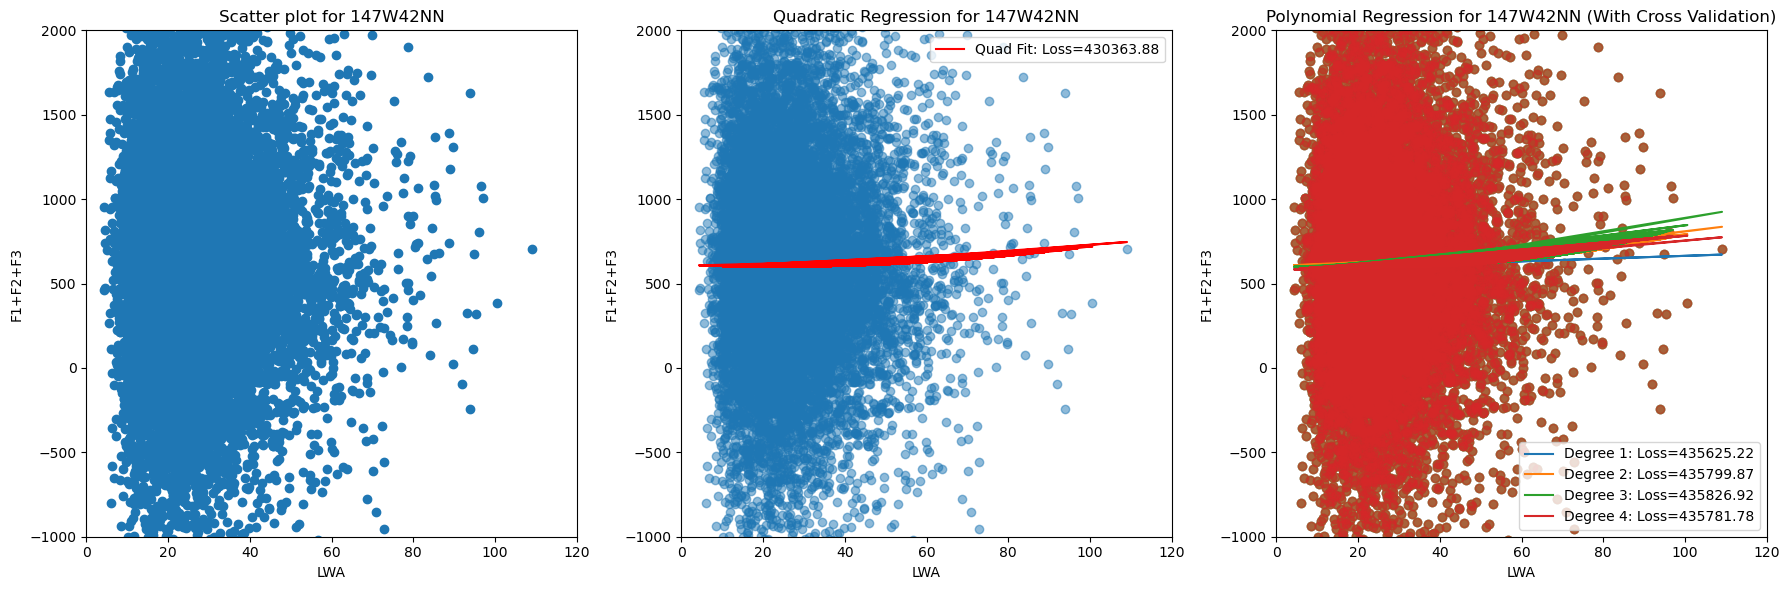

Processing points: 100%|██████████| 4/4 [00:10<00:00,  2.67s/it]


In [2]:
'''
Env: Python 3.9
The first sector of code is depreciated.
Method plot_hovmoller(weekly_data) plots NH18 Fig 1D
Mthod plot_scatter(data, idx) plots NH18 Fig 4
Last 2 code sectors implements methods to perform ploynomial regression
'''

import os
import re
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from joblib import Parallel, delayed
from tqdm import tqdm

# Load data
def load_data(directory):
    # Regular expression to match years from 1979 to 2016, and months as 1, 2, 12.
    pattern = re.compile(r'_(1979|198[0-9]|199[0-9]|200[0-9]|201[0-6])_(01|02|12)_')

    LWA_files = [f for f in os.listdir(directory) if f.startswith("column_LWA") and pattern.search(f)]
    F1_files = [f for f in os.listdir(directory) if f.startswith("F1_") and pattern.search(f)]
    F2_files = [f for f in os.listdir(directory) if f.startswith("F2_") and pattern.search(f)]
    F3_files = [f for f in os.listdir(directory) if f.startswith("F3_") and pattern.search(f)]

    # Parallelize data loading
    with Parallel(n_jobs=-1) as parallel:
        LWA_data = parallel(delayed(np.load)(os.path.join(directory, f)) for f in LWA_files)
        F1_data = parallel(delayed(np.load)(os.path.join(directory, f)) for f in F1_files)
        F2_data = parallel(delayed(np.load)(os.path.join(directory, f)) for f in F2_files)
        F3_data = parallel(delayed(np.load)(os.path.join(directory, f)) for f in F3_files)

    return LWA_data, F1_data, F2_data, F3_data

# Plot scatter and regression
def plot_regression(indices, LWA_data, F1_data, F2_data, F3_data):
    for label, (x_idx, y_idx) in tqdm(indices.items(), desc="Processing points"):
        LWA_values = [data[x_idx, y_idx] for data in LWA_data]
        F_values = [f1[x_idx, y_idx] + f2[x_idx, y_idx] + f3[x_idx, y_idx] for f1, f2, f3 in zip(F1_data, F2_data, F3_data)]

        fig, axes = plt.subplots(1, 3, figsize=(18, 6))

        # Set the common axis properties
        for ax in axes:
            ax.set_xlim(0, 120)
            ax.set_ylim(-1000, 2000)
        
        # Scatter plot
        axes[0].scatter(LWA_values, F_values)
        axes[0].set_title(f'Scatter plot for {label}')
        axes[0].set_xlabel('LWA')
        axes[0].set_ylabel('F1+F2+F3')

        for degree in [1, 2]:  # Linear and Quadratic
            poly = PolynomialFeatures(degree=degree)
            X_poly = poly.fit_transform(np.array(LWA_values).reshape(-1, 1))
            
            reg = LinearRegression().fit(X_poly, F_values)
            y_pred = reg.predict(X_poly)
            
            # Quadratic regression fit plot
            if degree == 2:
                axes[1].scatter(LWA_values, F_values, alpha=0.5)
                axes[1].plot(LWA_values, y_pred, color='red', label=f'Quad Fit: Loss={mean_squared_error(F_values, y_pred):.2f}')
                axes[1].set_title(f'Quadratic Regression for {label}')
                axes[1].legend()
                axes[1].set_xlabel('LWA')
                axes[1].set_ylabel('F1+F2+F3')

        # Polynomial regression fit plot (with cross-validation)
        for degree in [1, 2, 3, 4]:  # Linear, Quadratic, Cubic, and Quartic
            poly = PolynomialFeatures(degree=degree)
            X_poly = poly.fit_transform(np.array(LWA_values).reshape(-1, 1))
            X_train, X_val, y_train, y_val = train_test_split(X_poly, F_values, test_size=0.2, random_state=42)
            reg = LinearRegression().fit(X_train, y_train)
            
            y_pred = reg.predict(X_poly)
            loss = mean_squared_error(y_val, reg.predict(X_val))
            
            axes[2].scatter(LWA_values, F_values, alpha=0.5)
            axes[2].plot(LWA_values, y_pred, label=f'Degree {degree}: Loss={loss:.2f}')
            axes[2].set_title(f'Polynomial Regression for {label} (With Cross Validation)')
            axes[2].legend()
            axes[2].set_xlabel('LWA')
            axes[2].set_ylabel('F1+F2+F3')

        plt.tight_layout()
        plt.show()

directory = "/scratch/negishi/yan481/KenYan_Traffic_Model/hn2016-falwa_calculation"
LWA_data, F1_data, F2_data, F3_data = load_data(directory)
indices = {
    '9W45N': (90, 114),
    '147W42N': (88, 22),
    '9W45NN': (90, 234),
    '147W42NN': (88, 142)
#     '9E45N': (90, 126),
#     '9W45S': (30, 114)
}
plot_regression(indices, LWA_data, F1_data, F2_data, F3_data)


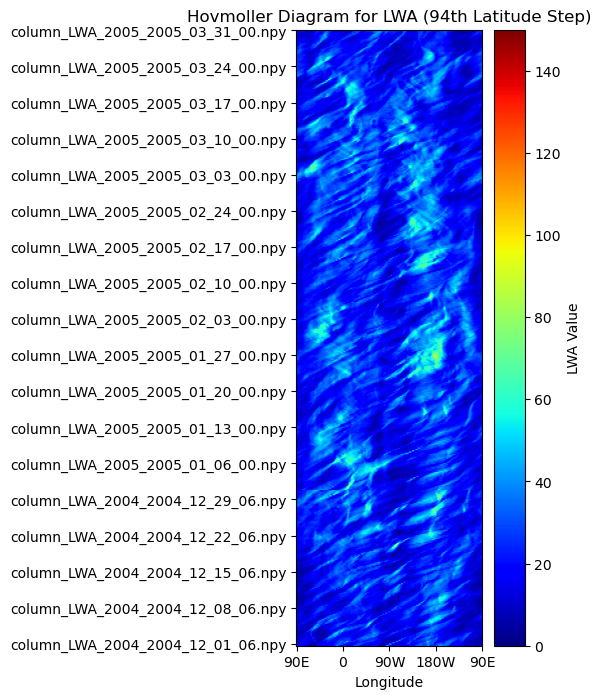

In [7]:
import os
import re
import numpy as np
import matplotlib.pyplot as plt

# Load data for the specified months
def load_data(directory):
    # Regular expression to match specific months for the years 2004-2005.
    pattern = re.compile(r'_(2004_12|2005_(01|02|03))_')

    LWA_files = sorted([f for f in os.listdir(directory) if f.startswith("column_LWA") and pattern.search(f)])
    
    # Loading data from each matched file
    weekly_data = []

    for f in LWA_files:
        weekly_data.append((f, np.load(os.path.join(directory, f))))

    return weekly_data

# Extract the desired data and plot the Hovmoller diagram
def plot_hovmoller(weekly_data):
    # Extract the 94th latitude step for each week
    data_for_plot = [data[1][93, :] for data in weekly_data]  # 0-based indexing
    
    # Reorder the longitudes
    reordered_data = [np.concatenate((row[60:], row[:60])) for row in data_for_plot]
    
    # Reverse the order of data to plot with latest time at the top
    reordered_data = reordered_data[::-1]

    fig, ax = plt.subplots(figsize=(3, 8))
    c = ax.imshow(reordered_data, aspect='auto', cmap='jet', vmin=0, vmax=150)
    ax.set_yticks(list(range(0, len(weekly_data), 28)))
    ax.set_yticklabels([weekly_data[i][0] for i in range(len(weekly_data)-1, -1, -28)])  # 每28个文件显示一个文件名
    ax.set_xticks(list(range(0, 241, 60)))
    ax.set_xticklabels(['90E', '0', '90W', '180W', '90E'])  
    ax.set_xlabel("Longitude")
    ax.set_title("Hovmoller Diagram for LWA (94th Latitude Step)")
    cbar = fig.colorbar(c)
    cbar.set_label('LWA Value')
    plt.show()

directory = "/scratch/negishi/yan481/KenYan_Traffic_Model/hn2016-falwa_calculation"
weekly_data = load_data(directory)
plot_hovmoller(weekly_data)


Year 1979:   0%|                                                             | 0/24 [00:00<?, ?it/s]
                                                                                                    
Year 1979:   0%|                                                             | 0/24 [00:00<?, ?it/s]
                                                                                                    
Year 1979:   0%|                                                             | 0/24 [00:00<?, ?it/s]
                                                                                                    
Year 1979:   0%|                                                             | 0/24 [00:00<?, ?it/s]
                                                                                                    
Year 1979:   0%|                                                             | 0/24 [00:00<?, ?it/s]
                                                                                           

Year 1984:   0%|                                                             | 0/24 [00:00<?, ?it/s]
                                                                                                    
Year 1984:   0%|                                                             | 0/24 [00:00<?, ?it/s]
                                                                                                    
Year 1984:   0%|                                                             | 0/24 [00:00<?, ?it/s]
                                                                                                    
Year 1984:   0%|                                                             | 0/24 [00:00<?, ?it/s]
                                                                                                    
Year 1984:   0%|                                                             | 0/24 [00:00<?, ?it/s]
                                                                                           

                                                                                                    
Year 1989: 100%|███████████████████████████████████████████████████| 24/24 [00:00<00:00, 238.28it/s]
                                                                                                    
Year 1989:   0%|                                                             | 0/24 [00:00<?, ?it/s]
                                                                                                    
Year 1989:   0%|                                                             | 0/24 [00:00<?, ?it/s]
                                                                                                    
Year 1989:  54%|███████████████████████████▌                       | 13/24 [00:00<00:00, 102.89it/s]
                                                                                                    
Year 1989:  62%|███████████████████████████████▉                   | 15/24 [00:00<00:00, 13

Year 1992:  50%|█████████████████████████▌                         | 12/24 [00:00<00:00, 114.50it/s]
                                                                                                    
Year 1992: 100%|███████████████████████████████████████████████████| 24/24 [00:00<00:00, 232.17it/s]
                                                                                                    
Year 1992:   0%|                                                             | 0/24 [00:00<?, ?it/s]
                                                                                                    
Year 1992:   0%|                                                             | 0/24 [00:00<?, ?it/s]
                                                                                                    
Year 1992:  42%|█████████████████████▋                              | 10/24 [00:00<00:00, 99.23it/s]
                                                                                           

Year 1996:  71%|████████████████████████████████████▏              | 17/24 [00:00<00:00, 167.63it/s]
                                                                                                    
Year 1996:  75%|██████████████████████████████████████▎            | 18/24 [00:00<00:00, 179.05it/s]
                                                                                                    
Year 1996:  71%|████████████████████████████████████▏              | 17/24 [00:00<00:00, 157.64it/s]
                                                                                                    
Year 1996:  96%|█████████████████████████████████████████████████▊  | 23/24 [00:00<00:00, 69.09it/s]
                                                                                                    
Year 1996:  83%|███████████████████████████████████████████▎        | 20/24 [00:00<00:00, 66.78it/s]
                                                                                           

Year 1998:  62%|███████████████████████████████▉                   | 15/24 [00:00<00:00, 138.18it/s]
                                                                                                    
Year 1999:  79%|█████████████████████████████████████████▏          | 19/24 [00:00<00:00, 81.60it/s]
                                                                                                    
Year 1999: 100%|███████████████████████████████████████████████████| 24/24 [00:00<00:00, 118.45it/s]
                                                                                                    
Year 1999:  92%|██████████████████████████████████████████████▊    | 22/24 [00:00<00:00, 103.05it/s]
                                                                                                    
Year 1999:  83%|██████████████████████████████████████████▌        | 20/24 [00:00<00:00, 185.31it/s]
                                                                                           

Year 2001:  54%|███████████████████████████▌                       | 13/24 [00:00<00:00, 120.40it/s]
                                                                                                    
Year 2001:  54%|███████████████████████████▌                       | 13/24 [00:00<00:00, 126.04it/s]
                                                                                                    
Year 2001:  88%|████████████████████████████████████████████▋      | 21/24 [00:00<00:00, 103.10it/s]
                                                                                                    
Year 2001:  88%|█████████████████████████████████████████████▌      | 21/24 [00:00<00:00, 90.94it/s]
                                                                                                    
Year 2002:  58%|██████████████████████████████▎                     | 14/24 [00:00<00:00, 69.65it/s]
                                                                                           

Year 2004:  46%|███████████████████████▍                           | 11/24 [00:00<00:00, 107.05it/s]
                                                                                                    
Year 2004: 100%|███████████████████████████████████████████████████| 24/24 [00:00<00:00, 113.83it/s]
                                                                                                    
Year 2004: 100%|███████████████████████████████████████████████████| 24/24 [00:00<00:00, 105.27it/s]
                                                                                                    
Year 2004:  54%|███████████████████████████▌                       | 13/24 [00:00<00:00, 118.15it/s]
                                                                                                    
Year 2004:  79%|████████████████████████████████████████▍          | 19/24 [00:00<00:00, 168.52it/s]
                                                                                           

Year 2007:  33%|█████████████████▋                                   | 8/24 [00:00<00:00, 72.19it/s]
                                                                                                    
Year 2007:  21%|███████████                                          | 5/24 [00:00<00:00, 40.57it/s]
                                                                                                    
Year 2007:  71%|████████████████████████████████████▊               | 17/24 [00:00<00:00, 79.58it/s]
                                                                                                    
Year 2007:  75%|███████████████████████████████████████             | 18/24 [00:00<00:00, 66.13it/s]
                                                                                                    
Year 2007:  58%|█████████████████████████████▊                     | 14/24 [00:00<00:00, 137.60it/s]
                                                                                           

Year 2010:  96%|█████████████████████████████████████████████████▊  | 23/24 [00:00<00:00, 72.68it/s]
                                                                                                    
Year 2010:  38%|███████████████████▉                                 | 9/24 [00:00<00:00, 86.63it/s]
                                                                                                    
Year 2010:  42%|█████████████████████▋                              | 10/24 [00:00<00:00, 61.06it/s]
                                                                                                    
Year 2010:  54%|███████████████████████████▌                       | 13/24 [00:00<00:00, 121.05it/s]
                                                                                                    
Year 2010:  58%|█████████████████████████████▊                     | 14/24 [00:00<00:00, 139.22it/s]
                                                                                           

                                                                                                    
Year 2013:  96%|█████████████████████████████████████████████████▊  | 23/24 [00:00<00:00, 94.52it/s]
                                                                                                    
Year 2013:  75%|███████████████████████████████████████             | 18/24 [00:00<00:00, 88.56it/s]
                                                                                                    
Year 2013:  58%|█████████████████████████████▊                     | 14/24 [00:00<00:00, 130.45it/s]
                                                                                                    
Year 2013:  83%|███████████████████████████████████████████▎        | 20/24 [00:00<00:00, 98.34it/s]
                                                                                                    
Year 2013:  58%|█████████████████████████████▊                     | 14/24 [00:00<00:00, 12

                                                                                                    
Year 1979: 100%|███████████████████████████████████████████████████| 24/24 [00:00<00:00, 116.61it/s]
                                                                                                    
Year 1979: 100%|███████████████████████████████████████████████████| 24/24 [00:00<00:00, 111.90it/s]
                                                                                                    
Year 1979:  58%|█████████████████████████████▊                     | 14/24 [00:00<00:00, 138.76it/s]
                                                                                                    
Year 1979:  79%|████████████████████████████████████████▍          | 19/24 [00:00<00:00, 189.25it/s]
                                                                                                    
Year 1979:  58%|█████████████████████████████▊                     | 14/24 [00:00<00:00, 13

Year 1982:  58%|█████████████████████████████▊                     | 14/24 [00:00<00:00, 122.66it/s]
                                                                                                    
Year 1982:  88%|█████████████████████████████████████████████▌      | 21/24 [00:00<00:00, 98.29it/s]
                                                                                                    
Year 1982:  62%|███████████████████████████████▉                   | 15/24 [00:00<00:00, 130.24it/s]
                                                                                                    
Year 1982:  79%|████████████████████████████████████████▍          | 19/24 [00:00<00:00, 188.86it/s]
                                                                                                    
Year 1982: 100%|███████████████████████████████████████████████████| 24/24 [00:00<00:00, 116.22it/s]
                                                                                           

                                                                                                    
Year 1984:  62%|███████████████████████████████▉                   | 15/24 [00:00<00:00, 142.42it/s]
                                                                                                    
Year 1985:  54%|███████████████████████████▌                       | 13/24 [00:00<00:00, 128.97it/s]
                                                                                                    
Year 1985:  83%|███████████████████████████████████████████▎        | 20/24 [00:00<00:00, 78.52it/s]
                                                                                                    
Year 1985:  71%|████████████████████████████████████▏              | 17/24 [00:00<00:00, 167.82it/s]
                                                                                                    
Year 1985:  58%|██████████████████████████████▎                     | 14/24 [00:00<00:00, 7

Year 1987:  67%|██████████████████████████████████▋                 | 16/24 [00:00<00:00, 51.94it/s]
                                                                                                    
Year 1987:  96%|█████████████████████████████████████████████████▊  | 23/24 [00:00<00:00, 82.21it/s]
                                                                                                    
Year 1988:  88%|█████████████████████████████████████████████▌      | 21/24 [00:00<00:00, 72.75it/s]
                                                                                                    
Year 1988:  71%|████████████████████████████████████▊               | 17/24 [00:00<00:00, 57.68it/s]
                                                                                                    
Year 1988:  88%|█████████████████████████████████████████████▌      | 21/24 [00:00<00:00, 64.55it/s]
                                                                                           

                                                                                                    
Year 1990:  71%|████████████████████████████████████▏              | 17/24 [00:00<00:00, 155.47it/s]
                                                                                                    
Year 1990:  79%|█████████████████████████████████████████▏          | 19/24 [00:00<00:00, 85.08it/s]
                                                                                                    
Year 1990:  71%|████████████████████████████████████▏              | 17/24 [00:00<00:00, 163.04it/s]
                                                                                                    
Year 1990:  67%|██████████████████████████████████▋                 | 16/24 [00:00<00:00, 78.70it/s]
                                                                                                    
Year 1990:  54%|███████████████████████████▌                       | 13/24 [00:00<00:00, 11

Year 1993:  67%|██████████████████████████████████                 | 16/24 [00:00<00:00, 146.65it/s]
                                                                                                    
Year 1993:  67%|██████████████████████████████████                 | 16/24 [00:00<00:00, 145.78it/s]
                                                                                                    
Year 1993:  96%|█████████████████████████████████████████████████▊  | 23/24 [00:00<00:00, 28.53it/s]
                                                                                                    
Year 1993:  92%|███████████████████████████████████████████████▋    | 22/24 [00:00<00:00, 96.11it/s]
                                                                                                    
Year 1993:  54%|███████████████████████████▌                       | 13/24 [00:00<00:00, 127.57it/s]
                                                                                           

                                                                                                    
Year 1996:  88%|█████████████████████████████████████████████▌      | 21/24 [00:00<00:00, 94.47it/s]
                                                                                                    
Year 1996:  62%|████████████████████████████████▌                   | 15/24 [00:00<00:00, 72.96it/s]
                                                                                                    
Year 1996:  71%|████████████████████████████████████▊               | 17/24 [00:00<00:00, 56.61it/s]
                                                                                                    
Year 1996: 100%|███████████████████████████████████████████████████| 24/24 [00:00<00:00, 108.61it/s]
                                                                                                    
Year 1996:  58%|█████████████████████████████▊                     | 14/24 [00:00<00:00, 13

Year 1998:  75%|███████████████████████████████████████             | 18/24 [00:00<00:00, 87.35it/s]
                                                                                                    
Year 1999: 100%|████████████████████████████████████████████████████| 24/24 [00:00<00:00, 70.20it/s]
                                                                                                    
Year 1999:  88%|████████████████████████████████████████████▋      | 21/24 [00:00<00:00, 100.59it/s]
                                                                                                    
Year 1999:  42%|█████████████████████▋                              | 10/24 [00:00<00:00, 97.93it/s]
                                                                                                    
Year 1999:  96%|████████████████████████████████████████████████▉  | 23/24 [00:00<00:00, 110.50it/s]
                                                                                           

Year 2001: 100%|███████████████████████████████████████████████████| 24/24 [00:00<00:00, 118.74it/s]
                                                                                                    
Year 2001:  88%|█████████████████████████████████████████████▌      | 21/24 [00:00<00:00, 88.16it/s]
                                                                                                    
Year 2001:  71%|████████████████████████████████████▏              | 17/24 [00:00<00:00, 166.87it/s]
                                                                                                    
Year 2002:  92%|███████████████████████████████████████████████▋    | 22/24 [00:00<00:00, 90.04it/s]
                                                                                                    
Year 2002:  88%|█████████████████████████████████████████████▌      | 21/24 [00:00<00:00, 75.77it/s]
                                                                                           

Year 2004:  29%|███████████████▍                                     | 7/24 [00:00<00:00, 53.85it/s]
                                                                                                    
Year 2004:  29%|███████████████▍                                     | 7/24 [00:00<00:00, 68.55it/s]
                                                                                                    
Year 2004:  54%|███████████████████████████▌                       | 13/24 [00:00<00:00, 127.45it/s]
                                                                                                    
Year 2005:  71%|████████████████████████████████████▏              | 17/24 [00:00<00:00, 108.91it/s]
                                                                                                    
Year 2005:  96%|████████████████████████████████████████████████▉  | 23/24 [00:00<00:00, 211.77it/s]
                                                                                           

Year 2008:  96%|████████████████████████████████████████████████▉  | 23/24 [00:00<00:00, 229.74it/s]
                                                                                                    
Year 2008:  58%|█████████████████████████████▊                     | 14/24 [00:00<00:00, 139.01it/s]
                                                                                                    
Year 2008:  50%|█████████████████████████▌                         | 12/24 [00:00<00:00, 117.40it/s]
                                                                                                    
Year 2008:  83%|██████████████████████████████████████████▌        | 20/24 [00:00<00:00, 195.03it/s]
                                                                                                    
Year 2008:  58%|█████████████████████████████▊                     | 14/24 [00:00<00:00, 122.65it/s]
                                                                                           

Year 2011:  79%|████████████████████████████████████████▍          | 19/24 [00:00<00:00, 186.23it/s]
                                                                                                    
Year 2011:   0%|                                                             | 0/24 [00:00<?, ?it/s]
                                                                                                    
Year 2011:  50%|█████████████████████████▌                         | 12/24 [00:00<00:00, 107.85it/s]
                                                                                                    
Year 2012:   0%|                                                             | 0/24 [00:00<?, ?it/s]
                                                                                                    
Year 2012:  96%|████████████████████████████████████████████████▉  | 23/24 [00:00<00:00, 229.29it/s]
                                                                                           

Year 2014:  88%|█████████████████████████████████████████████▌      | 21/24 [00:00<00:00, 28.93it/s]
                                                                                                    
Year 2014:  96%|█████████████████████████████████████████████████▊  | 23/24 [00:00<00:00, 68.10it/s]
                                                                                                    
Year 2014:  83%|███████████████████████████████████████████▎        | 20/24 [00:00<00:00, 47.13it/s]
                                                                                                    
Year 2014: 100%|████████████████████████████████████████████████████| 24/24 [00:00<00:00, 71.41it/s]
                                                                                                    
Year 2015:  71%|████████████████████████████████████▊               | 17/24 [00:00<00:00, 78.12it/s]
                                                                                           

                                                                                                    
Year 1979: 100%|████████████████████████████████████████████████████| 24/24 [00:00<00:00, 65.40it/s]
                                                                                                    
Year 1979:  79%|█████████████████████████████████████████▏          | 19/24 [00:00<00:00, 49.87it/s]
                                                                                                    
Year 1979:  79%|█████████████████████████████████████████▏          | 19/24 [00:00<00:00, 56.52it/s]
                                                                                                    
Year 1979: 100%|████████████████████████████████████████████████████| 24/24 [00:00<00:00, 69.16it/s]
                                                                                                    
Year 1980:  71%|████████████████████████████████████▊               | 17/24 [00:00<00:00, 7

Year 1981:  79%|█████████████████████████████████████████▏          | 19/24 [00:00<00:00, 38.80it/s]
                                                                                                    
Year 1981:  92%|███████████████████████████████████████████████▋    | 22/24 [00:00<00:00, 42.30it/s]
                                                                                                    
Year 1981:  88%|█████████████████████████████████████████████▌      | 21/24 [00:00<00:00, 55.47it/s]
                                                                                                    
Year 1982:  83%|███████████████████████████████████████████▎        | 20/24 [00:00<00:00, 56.43it/s]
                                                                                                    
Year 1982:  96%|█████████████████████████████████████████████████▊  | 23/24 [00:00<00:00, 52.38it/s]
                                                                                           

Year 1983:  92%|███████████████████████████████████████████████▋    | 22/24 [00:00<00:00, 46.40it/s]
                                                                                                    
Year 1983: 100%|████████████████████████████████████████████████████| 24/24 [00:00<00:00, 55.76it/s]
                                                                                                    
Year 1983: 100%|████████████████████████████████████████████████████| 24/24 [00:00<00:00, 60.03it/s]
                                                                                                    
Year 1984:  71%|████████████████████████████████████▊               | 17/24 [00:00<00:00, 53.03it/s]
                                                                                                    
Year 1984:  75%|███████████████████████████████████████             | 18/24 [00:00<00:00, 55.36it/s]
                                                                                           

Year 1985: 100%|████████████████████████████████████████████████████| 24/24 [00:00<00:00, 62.89it/s]
                                                                                                    
Year 1985:  88%|█████████████████████████████████████████████▌      | 21/24 [00:00<00:00, 43.02it/s]
                                                                                                    
Year 1986:  71%|████████████████████████████████████▊               | 17/24 [00:00<00:00, 55.01it/s]
                                                                                                    
Year 1986:  79%|█████████████████████████████████████████▏          | 19/24 [00:00<00:00, 65.61it/s]
                                                                                                    
Year 1986:  88%|█████████████████████████████████████████████▌      | 21/24 [00:00<00:00, 55.53it/s]
                                                                                           

Year 1987:  83%|███████████████████████████████████████████▎        | 20/24 [00:00<00:00, 59.83it/s]
                                                                                                    
Year 1988:  92%|███████████████████████████████████████████████▋    | 22/24 [00:00<00:00, 58.22it/s]
                                                                                                    
Year 1988:  71%|████████████████████████████████████▊               | 17/24 [00:00<00:00, 57.38it/s]
                                                                                                    
Year 1988:  92%|███████████████████████████████████████████████▋    | 22/24 [00:00<00:00, 68.50it/s]
                                                                                                    
Year 1988:  71%|████████████████████████████████████▊               | 17/24 [00:00<00:00, 81.27it/s]
                                                                                           

Year 1990:  83%|███████████████████████████████████████████▎        | 20/24 [00:00<00:00, 44.40it/s]
                                                                                                    
Year 1990:  92%|███████████████████████████████████████████████▋    | 22/24 [00:00<00:00, 51.27it/s]
                                                                                                    
Year 1990:  75%|███████████████████████████████████████             | 18/24 [00:00<00:00, 71.52it/s]
                                                                                                    
Year 1990:  88%|█████████████████████████████████████████████▌      | 21/24 [00:00<00:00, 57.98it/s]
                                                                                                    
Year 1990:  79%|█████████████████████████████████████████▏          | 19/24 [00:00<00:00, 60.46it/s]
                                                                                           

Year 1992:  88%|█████████████████████████████████████████████▌      | 21/24 [00:00<00:00, 59.06it/s]
                                                                                                    
Year 1992:  88%|█████████████████████████████████████████████▌      | 21/24 [00:00<00:00, 46.03it/s]
                                                                                                    
Year 1992: 100%|████████████████████████████████████████████████████| 24/24 [00:00<00:00, 62.92it/s]
                                                                                                    
Year 1992:  88%|█████████████████████████████████████████████▌      | 21/24 [00:00<00:00, 56.03it/s]
                                                                                                    
Year 1992:  83%|███████████████████████████████████████████▎        | 20/24 [00:00<00:00, 38.75it/s]
                                                                                           

Year 1994:  92%|███████████████████████████████████████████████▋    | 22/24 [00:00<00:00, 49.65it/s]
                                                                                                    
Year 1994:  88%|█████████████████████████████████████████████▌      | 21/24 [00:00<00:00, 61.54it/s]
                                                                                                    
Year 1994:  83%|███████████████████████████████████████████▎        | 20/24 [00:00<00:00, 57.68it/s]
                                                                                                    
Year 1994:  88%|█████████████████████████████████████████████▌      | 21/24 [00:00<00:00, 50.99it/s]
                                                                                                    
Year 1994:  83%|███████████████████████████████████████████▎        | 20/24 [00:00<00:00, 56.75it/s]
                                                                                           

Year 1996: 100%|████████████████████████████████████████████████████| 24/24 [00:00<00:00, 75.04it/s]
                                                                                                    
Year 1996: 100%|████████████████████████████████████████████████████| 24/24 [00:00<00:00, 57.27it/s]
                                                                                                    
Year 1996:  92%|███████████████████████████████████████████████▋    | 22/24 [00:00<00:00, 63.74it/s]
                                                                                                    
Year 1996:  96%|█████████████████████████████████████████████████▊  | 23/24 [00:00<00:00, 74.97it/s]
                                                                                                    
Year 1996:  88%|█████████████████████████████████████████████▌      | 21/24 [00:00<00:00, 62.78it/s]
                                                                                           

Year 1998: 100%|████████████████████████████████████████████████████| 24/24 [00:00<00:00, 71.88it/s]
                                                                                                    
Year 1998:  88%|█████████████████████████████████████████████▌      | 21/24 [00:00<00:00, 41.66it/s]
                                                                                                    
Year 1998:  92%|███████████████████████████████████████████████▋    | 22/24 [00:00<00:00, 65.32it/s]
                                                                                                    
Year 1998:  75%|███████████████████████████████████████             | 18/24 [00:00<00:00, 47.77it/s]
                                                                                                    
Year 1998:  88%|█████████████████████████████████████████████▌      | 21/24 [00:00<00:00, 63.09it/s]
                                                                                           

Year 2000:  79%|█████████████████████████████████████████▏          | 19/24 [00:00<00:00, 52.55it/s]
                                                                                                    
Year 2000: 100%|████████████████████████████████████████████████████| 24/24 [00:00<00:00, 41.95it/s]
                                                                                                    
Year 2000:  88%|█████████████████████████████████████████████▌      | 21/24 [00:00<00:00, 66.60it/s]
                                                                                                    
Year 2000:  83%|███████████████████████████████████████████▎        | 20/24 [00:00<00:00, 25.87it/s]
                                                                                                    
Year 2000:  92%|███████████████████████████████████████████████▋    | 22/24 [00:00<00:00, 67.22it/s]
                                                                                           

Year 2002:  79%|█████████████████████████████████████████▏          | 19/24 [00:00<00:00, 59.93it/s]
                                                                                                    
Year 2002:  96%|█████████████████████████████████████████████████▊  | 23/24 [00:00<00:00, 53.16it/s]
                                                                                                    
Year 2002:  96%|█████████████████████████████████████████████████▊  | 23/24 [00:00<00:00, 57.33it/s]
                                                                                                    
Year 2002:  83%|███████████████████████████████████████████▎        | 20/24 [00:00<00:00, 54.88it/s]
                                                                                                    
Year 2002:  88%|█████████████████████████████████████████████▌      | 21/24 [00:00<00:00, 63.61it/s]
                                                                                           

Year 2004:  96%|█████████████████████████████████████████████████▊  | 23/24 [00:00<00:00, 52.07it/s]
                                                                                                    
Year 2004:  88%|█████████████████████████████████████████████▌      | 21/24 [00:00<00:00, 62.88it/s]
                                                                                                    
Year 2004: 100%|████████████████████████████████████████████████████| 24/24 [00:00<00:00, 65.64it/s]
                                                                                                    
Year 2004:  75%|███████████████████████████████████████             | 18/24 [00:00<00:00, 53.19it/s]
                                                                                                    
Year 2004:  96%|█████████████████████████████████████████████████▊  | 23/24 [00:00<00:00, 39.52it/s]
                                                                                           

Year 2006:  88%|█████████████████████████████████████████████▌      | 21/24 [00:00<00:00, 51.56it/s]
                                                                                                    
Year 2006:  83%|███████████████████████████████████████████▎        | 20/24 [00:00<00:00, 52.06it/s]
                                                                                                    
Year 2006: 100%|████████████████████████████████████████████████████| 24/24 [00:00<00:00, 69.50it/s]
                                                                                                    
Year 2006:  79%|█████████████████████████████████████████▏          | 19/24 [00:00<00:00, 59.93it/s]
                                                                                                    
Year 2006: 100%|████████████████████████████████████████████████████| 24/24 [00:00<00:00, 64.75it/s]
                                                                                           

                                                                                                    
Year 2008:  92%|███████████████████████████████████████████████▋    | 22/24 [00:00<00:00, 73.69it/s]
                                                                                                    
Year 2008:  88%|█████████████████████████████████████████████▌      | 21/24 [00:00<00:00, 53.02it/s]
                                                                                                    
Year 2008:  92%|███████████████████████████████████████████████▋    | 22/24 [00:00<00:00, 53.34it/s]
                                                                                                    
Year 2008:  71%|████████████████████████████████████▊               | 17/24 [00:00<00:00, 46.15it/s]
                                                                                                    
Year 2008:  88%|█████████████████████████████████████████████▌      | 21/24 [00:00<00:00, 6

Year 2010:  96%|█████████████████████████████████████████████████▊  | 23/24 [00:00<00:00, 40.27it/s]
                                                                                                    
Year 2010: 100%|████████████████████████████████████████████████████| 24/24 [00:00<00:00, 53.47it/s]
                                                                                                    
Year 2010: 100%|████████████████████████████████████████████████████| 24/24 [00:00<00:00, 51.38it/s]
                                                                                                    
Year 2010:  83%|███████████████████████████████████████████▎        | 20/24 [00:00<00:00, 55.09it/s]
                                                                                                    
Year 2010:  92%|███████████████████████████████████████████████▋    | 22/24 [00:00<00:00, 48.72it/s]
                                                                                           

                                                                                                    
Year 2012: 100%|████████████████████████████████████████████████████| 24/24 [00:00<00:00, 47.42it/s]
                                                                                                    
Year 2012:  83%|███████████████████████████████████████████▎        | 20/24 [00:00<00:00, 63.93it/s]
                                                                                                    
Year 2012:  88%|█████████████████████████████████████████████▌      | 21/24 [00:00<00:00, 60.45it/s]
                                                                                                    
Year 2012:  96%|█████████████████████████████████████████████████▊  | 23/24 [00:00<00:00, 61.82it/s]
                                                                                                    
Year 2012:  79%|█████████████████████████████████████████▏          | 19/24 [00:00<00:00, 5

Year 2014:  88%|█████████████████████████████████████████████▌      | 21/24 [00:00<00:00, 67.27it/s]
                                                                                                    
Year 2014: 100%|████████████████████████████████████████████████████| 24/24 [00:00<00:00, 57.49it/s]
                                                                                                    
Year 2014:  92%|███████████████████████████████████████████████▋    | 22/24 [00:00<00:00, 51.72it/s]
                                                                                                    
Year 2014:  96%|█████████████████████████████████████████████████▊  | 23/24 [00:00<00:00, 56.05it/s]
                                                                                                    
Year 2014:  83%|███████████████████████████████████████████▎        | 20/24 [00:00<00:00, 42.26it/s]
                                                                                           

Year 1979:  79%|█████████████████████████████████████████▏          | 19/24 [00:00<00:00, 52.66it/s]
                                                                                                    
Year 1979:  83%|███████████████████████████████████████████▎        | 20/24 [00:00<00:00, 34.13it/s]
                                                                                                    
Year 1979: 100%|████████████████████████████████████████████████████| 24/24 [00:00<00:00, 66.92it/s]
                                                                                                    
Year 1979:  96%|█████████████████████████████████████████████████▊  | 23/24 [00:00<00:00, 70.02it/s]
                                                                                                    
Year 1979:  96%|█████████████████████████████████████████████████▊  | 23/24 [00:00<00:00, 77.06it/s]
                                                                                           

Year 1981:  88%|█████████████████████████████████████████████▌      | 21/24 [00:00<00:00, 65.88it/s]
                                                                                                    
Year 1981:  92%|███████████████████████████████████████████████▋    | 22/24 [00:00<00:00, 63.76it/s]
                                                                                                    
Year 1981:  88%|█████████████████████████████████████████████▌      | 21/24 [00:00<00:00, 57.77it/s]
                                                                                                    
Year 1981:  88%|█████████████████████████████████████████████▌      | 21/24 [00:00<00:00, 52.84it/s]
                                                                                                    
Year 1981:  96%|█████████████████████████████████████████████████▊  | 23/24 [00:00<00:00, 53.75it/s]
                                                                                           

                                                                                                    
Year 1983: 100%|████████████████████████████████████████████████████| 24/24 [00:00<00:00, 67.16it/s]
                                                                                                    
Year 1983:  88%|█████████████████████████████████████████████▌      | 21/24 [00:00<00:00, 64.32it/s]
                                                                                                    
Year 1983:  92%|███████████████████████████████████████████████▋    | 22/24 [00:00<00:00, 63.75it/s]
                                                                                                    
Year 1983:  92%|███████████████████████████████████████████████▋    | 22/24 [00:00<00:00, 59.99it/s]
                                                                                                    
Year 1983:  75%|███████████████████████████████████████             | 18/24 [00:00<00:00, 3

Year 1985: 100%|████████████████████████████████████████████████████| 24/24 [00:00<00:00, 60.73it/s]
                                                                                                    
Year 1985: 100%|████████████████████████████████████████████████████| 24/24 [00:00<00:00, 71.75it/s]
                                                                                                    
Year 1985:  79%|█████████████████████████████████████████▏          | 19/24 [00:00<00:00, 57.91it/s]
                                                                                                    
Year 1985:  92%|███████████████████████████████████████████████▋    | 22/24 [00:00<00:00, 44.72it/s]
                                                                                                    
Year 1985:  96%|█████████████████████████████████████████████████▊  | 23/24 [00:00<00:00, 60.14it/s]
                                                                                           

Year 1987:  96%|█████████████████████████████████████████████████▊  | 23/24 [00:00<00:00, 63.40it/s]
                                                                                                    
Year 1987:  75%|███████████████████████████████████████             | 18/24 [00:00<00:00, 74.53it/s]
                                                                                                    
Year 1987:  75%|███████████████████████████████████████             | 18/24 [00:00<00:00, 66.96it/s]
                                                                                                    
Year 1987: 100%|████████████████████████████████████████████████████| 24/24 [00:00<00:00, 37.73it/s]
                                                                                                    
Year 1987:  88%|█████████████████████████████████████████████▌      | 21/24 [00:00<00:00, 57.27it/s]
                                                                                           

Year 1989:  96%|█████████████████████████████████████████████████▊  | 23/24 [00:00<00:00, 54.41it/s]
                                                                                                    
Year 1989:  92%|███████████████████████████████████████████████▋    | 22/24 [00:00<00:00, 66.74it/s]
                                                                                                    
Year 1989:  75%|███████████████████████████████████████             | 18/24 [00:00<00:00, 60.57it/s]
                                                                                                    
Year 1989:  92%|███████████████████████████████████████████████▋    | 22/24 [00:00<00:00, 66.69it/s]
                                                                                                    
Year 1989:  75%|███████████████████████████████████████             | 18/24 [00:00<00:00, 58.42it/s]
                                                                                           

Year 1991:  92%|███████████████████████████████████████████████▋    | 22/24 [00:00<00:00, 65.77it/s]
                                                                                                    
Year 1991:  75%|███████████████████████████████████████             | 18/24 [00:00<00:00, 47.76it/s]
                                                                                                    
Year 1991:  88%|█████████████████████████████████████████████▌      | 21/24 [00:00<00:00, 62.99it/s]
                                                                                                    
Year 1991:  96%|█████████████████████████████████████████████████▊  | 23/24 [00:00<00:00, 62.79it/s]
                                                                                                    
Year 1991:  88%|█████████████████████████████████████████████▌      | 21/24 [00:00<00:00, 52.35it/s]
                                                                                           

                                                                                                    
Year 1993:  96%|█████████████████████████████████████████████████▊  | 23/24 [00:00<00:00, 64.83it/s]
                                                                                                    
Year 1993:  83%|███████████████████████████████████████████▎        | 20/24 [00:00<00:00, 58.83it/s]
                                                                                                    
Year 1993: 100%|████████████████████████████████████████████████████| 24/24 [00:00<00:00, 76.10it/s]
                                                                                                    
Year 1993:  75%|███████████████████████████████████████             | 18/24 [00:00<00:00, 62.28it/s]
                                                                                                    
Year 1993:  71%|████████████████████████████████████▊               | 17/24 [00:00<00:00, 7

                                                                                                    
Year 1995:  88%|█████████████████████████████████████████████▌      | 21/24 [00:00<00:00, 26.84it/s]
                                                                                                    
Year 1995:  83%|███████████████████████████████████████████▎        | 20/24 [00:00<00:00, 67.55it/s]
                                                                                                    
Year 1995:  83%|███████████████████████████████████████████▎        | 20/24 [00:00<00:00, 44.77it/s]
                                                                                                    
Year 1995: 100%|████████████████████████████████████████████████████| 24/24 [00:00<00:00, 57.94it/s]
                                                                                                    
Year 1995:  92%|███████████████████████████████████████████████▋    | 22/24 [00:00<00:00, 4

                                                                                                    
Year 1997:  96%|█████████████████████████████████████████████████▊  | 23/24 [00:00<00:00, 64.95it/s]
                                                                                                    
Year 1997:  88%|█████████████████████████████████████████████▌      | 21/24 [00:00<00:00, 58.91it/s]
                                                                                                    
Year 1997:  75%|███████████████████████████████████████             | 18/24 [00:00<00:00, 48.02it/s]
                                                                                                    
Year 1997:  79%|█████████████████████████████████████████▏          | 19/24 [00:00<00:00, 55.56it/s]
                                                                                                    
Year 1998:  96%|█████████████████████████████████████████████████▊  | 23/24 [00:00<00:00, 6

Year 1999:  96%|█████████████████████████████████████████████████▊  | 23/24 [00:00<00:00, 65.79it/s]
                                                                                                    
Year 1999: 100%|████████████████████████████████████████████████████| 24/24 [00:00<00:00, 64.45it/s]
                                                                                                    
Year 1999:  79%|█████████████████████████████████████████▏          | 19/24 [00:00<00:00, 38.46it/s]
                                                                                                    
Year 1999:  83%|███████████████████████████████████████████▎        | 20/24 [00:00<00:00, 60.31it/s]
                                                                                                    
Year 1999: 100%|████████████████████████████████████████████████████| 24/24 [00:00<00:00, 45.06it/s]
                                                                                           

                                                                                                    
Year 2001: 100%|████████████████████████████████████████████████████| 24/24 [00:00<00:00, 65.34it/s]
                                                                                                    
Year 2001:  88%|█████████████████████████████████████████████▌      | 21/24 [00:00<00:00, 44.69it/s]
                                                                                                    
Year 2001:  83%|███████████████████████████████████████████▎        | 20/24 [00:00<00:00, 45.72it/s]
                                                                                                    
Year 2001:  92%|███████████████████████████████████████████████▋    | 22/24 [00:00<00:00, 49.97it/s]
                                                                                                    
Year 2001:  79%|█████████████████████████████████████████▏          | 19/24 [00:00<00:00, 5

                                                                                                    
Year 2003:  83%|███████████████████████████████████████████▎        | 20/24 [00:00<00:00, 50.22it/s]
                                                                                                    
Year 2003:  92%|███████████████████████████████████████████████▋    | 22/24 [00:00<00:00, 48.06it/s]
                                                                                                    
Year 2003:  79%|█████████████████████████████████████████▏          | 19/24 [00:00<00:00, 65.92it/s]
                                                                                                    
Year 2003:  83%|███████████████████████████████████████████▎        | 20/24 [00:00<00:00, 59.81it/s]
                                                                                                    
Year 2003:  92%|███████████████████████████████████████████████▋    | 22/24 [00:00<00:00, 7

Year 2005:  79%|█████████████████████████████████████████▏          | 19/24 [00:00<00:00, 56.41it/s]
                                                                                                    
Year 2005:  83%|███████████████████████████████████████████▎        | 20/24 [00:00<00:00, 32.50it/s]
                                                                                                    
Year 2005:  92%|███████████████████████████████████████████████▋    | 22/24 [00:00<00:00, 61.69it/s]
                                                                                                    
Year 2005:  83%|███████████████████████████████████████████▎        | 20/24 [00:00<00:00, 51.21it/s]
                                                                                                    
Year 2005:  92%|███████████████████████████████████████████████▋    | 22/24 [00:00<00:00, 67.58it/s]
                                                                                           

Year 2007:  92%|███████████████████████████████████████████████▋    | 22/24 [00:00<00:00, 66.53it/s]
                                                                                                    
Year 2007:  96%|█████████████████████████████████████████████████▊  | 23/24 [00:00<00:00, 65.13it/s]
                                                                                                    
Year 2007:  67%|██████████████████████████████████▋                 | 16/24 [00:00<00:00, 70.60it/s]
                                                                                                    
Year 2007: 100%|████████████████████████████████████████████████████| 24/24 [00:00<00:00, 45.82it/s]
                                                                                                    
Year 2007:  88%|█████████████████████████████████████████████▌      | 21/24 [00:00<00:00, 65.44it/s]
                                                                                           

Year 2009:  71%|████████████████████████████████████▊               | 17/24 [00:00<00:00, 73.53it/s]
                                                                                                    
Year 2009:  96%|█████████████████████████████████████████████████▊  | 23/24 [00:00<00:00, 45.59it/s]
                                                                                                    
Year 2009:  92%|███████████████████████████████████████████████▋    | 22/24 [00:00<00:00, 72.16it/s]
                                                                                                    
Year 2009:  96%|█████████████████████████████████████████████████▊  | 23/24 [00:00<00:00, 43.01it/s]
                                                                                                    
Year 2009:  75%|███████████████████████████████████████             | 18/24 [00:00<00:00, 57.39it/s]
                                                                                           

Year 2011:  88%|█████████████████████████████████████████████▌      | 21/24 [00:00<00:00, 47.46it/s]
                                                                                                    
Year 2011:  88%|█████████████████████████████████████████████▌      | 21/24 [00:00<00:00, 43.61it/s]
                                                                                                    
Year 2011:  88%|█████████████████████████████████████████████▌      | 21/24 [00:00<00:00, 40.24it/s]
                                                                                                    
Year 2011:  79%|█████████████████████████████████████████▏          | 19/24 [00:00<00:00, 44.50it/s]
                                                                                                    
Year 2011: 100%|████████████████████████████████████████████████████| 24/24 [00:00<00:00, 55.58it/s]
                                                                                           

                                                                                                    
Year 2013:  92%|███████████████████████████████████████████████▋    | 22/24 [00:00<00:00, 64.36it/s]
                                                                                                    
Year 2013:  88%|█████████████████████████████████████████████▌      | 21/24 [00:00<00:00, 54.17it/s]
                                                                                                    
Year 2013:  92%|███████████████████████████████████████████████▋    | 22/24 [00:00<00:00, 51.68it/s]
                                                                                                    
Year 2013: 100%|████████████████████████████████████████████████████| 24/24 [00:00<00:00, 49.51it/s]
                                                                                                    
Year 2013:  88%|█████████████████████████████████████████████▌      | 21/24 [00:00<00:00, 5

Year 2015:  96%|█████████████████████████████████████████████████▊  | 23/24 [00:00<00:00, 36.07it/s]
                                                                                                    
Year 2015:  92%|███████████████████████████████████████████████▋    | 22/24 [00:00<00:00, 51.69it/s]
                                                                                                    
Year 2015: 100%|████████████████████████████████████████████████████| 24/24 [00:00<00:00, 68.53it/s]
                                                                                                    
Year 2015:  79%|█████████████████████████████████████████▏          | 19/24 [00:00<00:00, 60.36it/s]
                                                                                                    
Year 2015:  92%|███████████████████████████████████████████████▋    | 22/24 [00:00<00:00, 67.14it/s]
                                                                                           

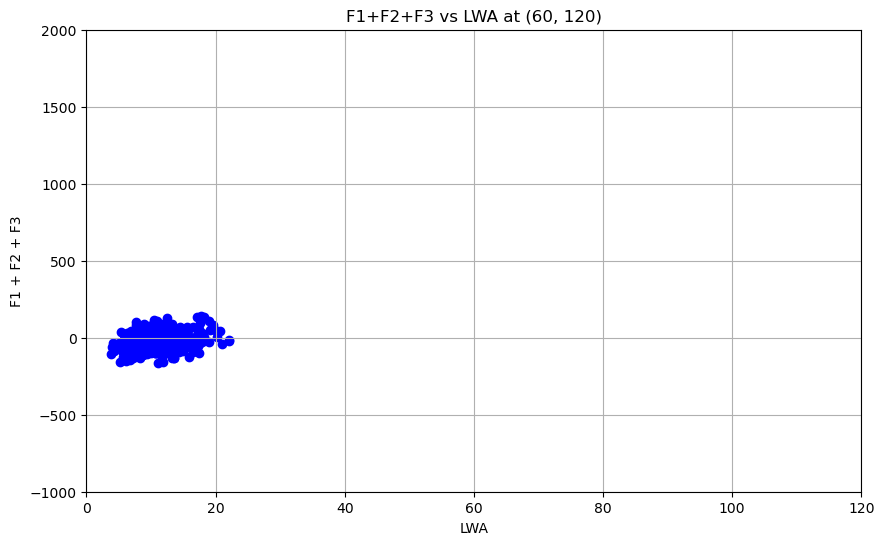

In [11]:
import os
import re
import numpy as np
import matplotlib.pyplot as plt
from concurrent.futures import ThreadPoolExecutor
from tqdm import tqdm

# Load data for specified months and years
def load_data(directory):
    years = [year for year in range(1979, 2016)]  # Up to 2016 as we are using data from the following year too

    pattern = re.compile(r'_(\d{4})_(12|01|02)_')

    def fetch_files(prefix):
        return sorted([f for f in os.listdir(directory) if f.startswith(prefix) and pattern.search(f)])

    LWA_files = fetch_files("column_LWA")
    F1_files = fetch_files("F1_")
    F2_files = fetch_files("F2_")
    F3_files = fetch_files("F3_")

    def average_files(files):
        avg_data = []

        for year in tqdm(years, desc='Processing years', ncols=100):  # Added progress bar for years
            winter_files = [f for f in files if f"_{year}_12_" in f or f"_{year+1}_01_" in f or f"_{year+1}_02_" in f]
            
            for start in range(0, len(winter_files), 24):
                chunk_files = winter_files[start:start+24]
                avg_data.append(np.mean([np.load(os.path.join(directory, file)) for file in tqdm(chunk_files, desc=f'Year {year}', leave=False, ncols=100)], axis=0))
                
        return avg_data

    LWA_data = average_files(LWA_files)
    F1_data = average_files(F1_files)
    F2_data = average_files(F2_files)
    F3_data = average_files(F3_files)

    return LWA_data, F1_data, F2_data, F3_data

# Extract data for the given indices and plot the scatter diagram
def plot_scatter(LWA_data, F1_data, F2_data, F3_data, idx=(60,120)):
    x_idx, y_idx = idx
    LWA_values = [data[x_idx, y_idx] for data in LWA_data]
    F_values = [f1[x_idx, y_idx] + f2[x_idx, y_idx] + f3[x_idx, y_idx] for f1, f2, f3 in zip(F1_data, F2_data, F3_data)]

    plt.figure(figsize=(10,6))
    plt.scatter(LWA_values, F_values, color='blue', marker='o')
    plt.xlabel('LWA')
    plt.ylabel('F1 + F2 + F3')
    plt.title(f'F1+F2+F3 vs LWA at {idx}')
    plt.ylim(-1000, 2000)
    plt.xlim(0, 120)
    plt.grid(True)
    plt.show()

directory = "/scratch/negishi/yan481/KenYan_Traffic_Model/hn2016-falwa_calculation"
LWA_data, F1_data, F2_data, F3_data = load_data(directory)
plot_scatter(LWA_data, F1_data, F2_data, F3_data, idx=(60,120))


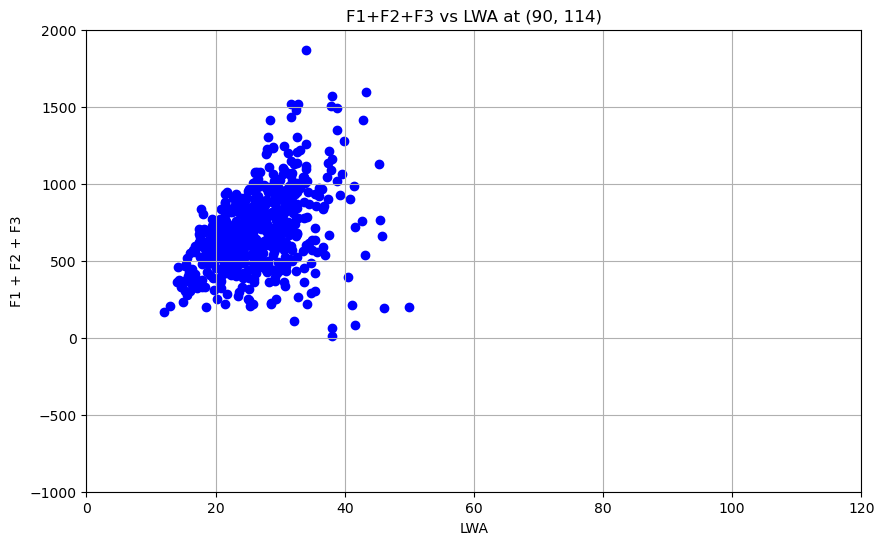

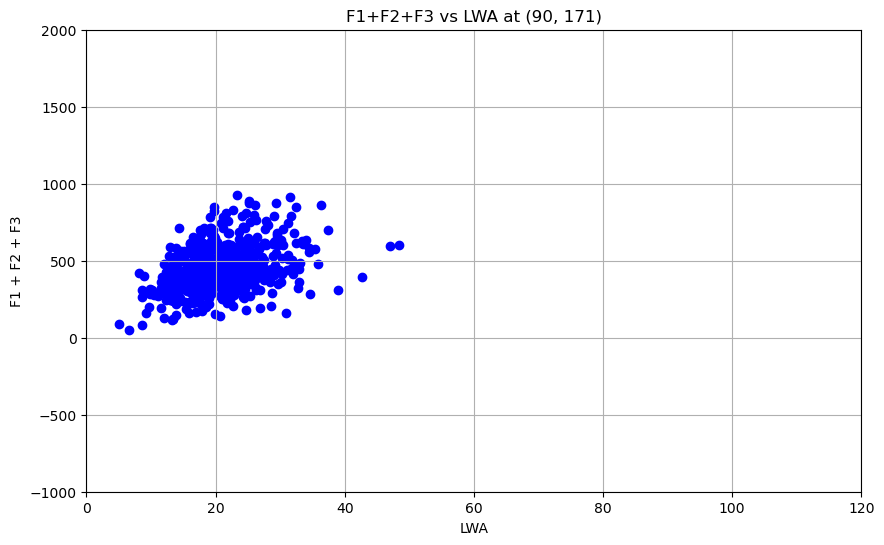

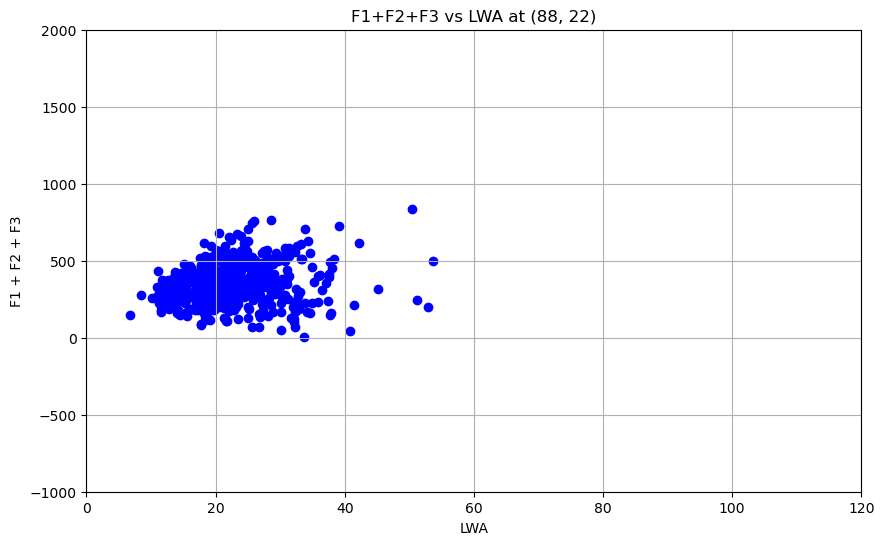

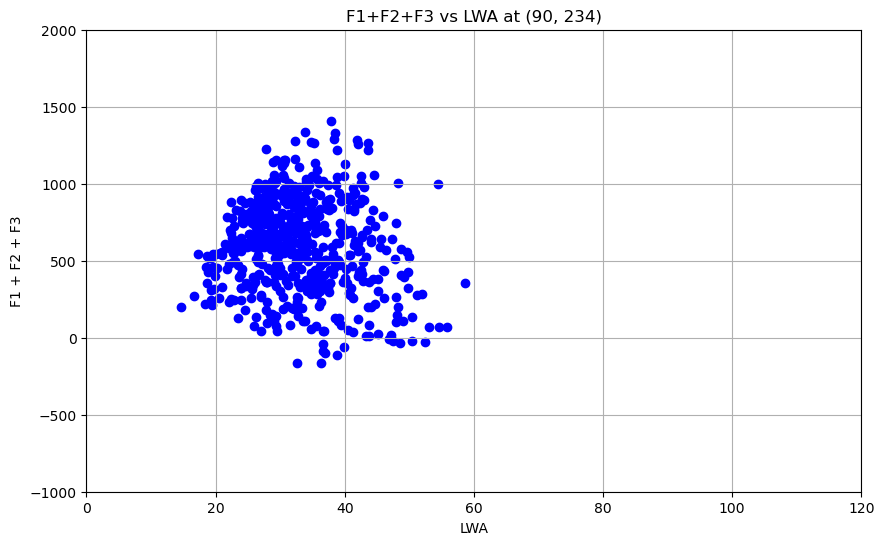

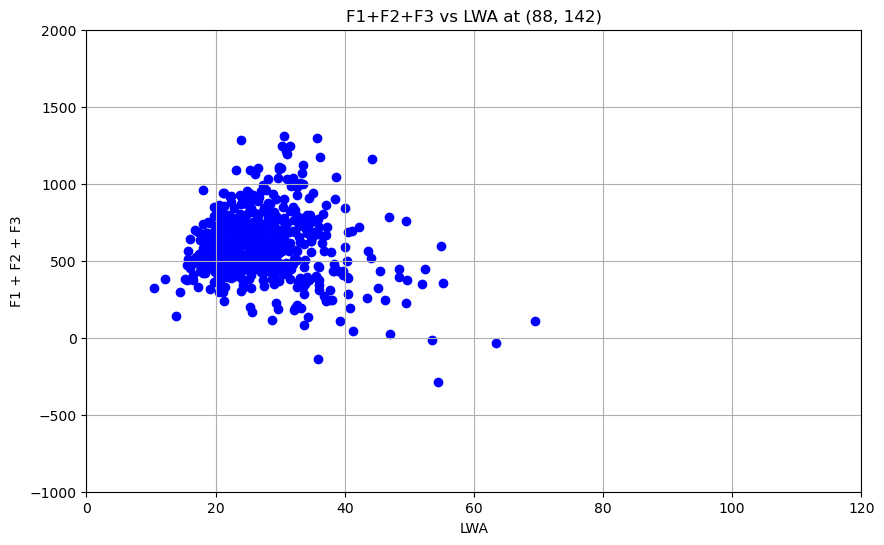

In [1]:
# 4-day avg

import os
import re
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

def load_data(directory):
    years = [year for year in range(1979, 2017)]  # Up to 2016 as we are using data from the following year too
    pattern = re.compile(r'_(\d{4})_(12|01|02)_')

    def fetch_files(prefix):
        return sorted([f for f in os.listdir(directory) if f.startswith(prefix) and pattern.search(f)])

    def average_files(files):
        avg_data = []
        for year in years:
            winter_files = [f for f in files if f"_{year}_12_" in f or f"_{year+1}_01_" in f or f"_{year+1}_02_" in f]
            for start in range(0, len(winter_files), 24):
                chunk_files = winter_files[start:start+24]
                avg_data.append(np.mean([np.load(os.path.join(directory, file)) for file in chunk_files], axis=0))
        return avg_data

    LWA_files = fetch_files("column_LWA")
    F1_files = fetch_files("F1_")
    F2_files = fetch_files("F2_")
    F3_files = fetch_files("F3_")

    return average_files(LWA_files), average_files(F1_files), average_files(F2_files), average_files(F3_files)

def plot_scatter(LWA_data, F1_data, F2_data, F3_data, idx):
    x_idx, y_idx = idx
    LWA_values = [data[x_idx, y_idx] for data in LWA_data]
    F_values = [f1[x_idx, y_idx] + f2[x_idx, y_idx] + f3[x_idx, y_idx] for f1, f2, f3 in zip(F1_data, F2_data, F3_data)]

    plt.figure(figsize=(10,6))
    plt.scatter(LWA_values, F_values, color='blue', marker='o')
    plt.xlabel('LWA')
    plt.ylabel('F1 + F2 + F3')
    plt.title(f'F1+F2+F3 vs LWA at {idx}')
    plt.ylim(-1000, 2000)
    plt.xlim(0, 120)
    plt.grid(True)
    plt.show()

directory = "/scratch/negishi/yan481/KenYan_Traffic_Model/hn2016-falwa_calculation"
LWA_data, F1_data, F2_data, F3_data = load_data(directory)
indices = [(90,114), (90, 171), (88, 22),(90, 234),(88, 142)]

for idx in indices:
    plot_scatter(LWA_data, F1_data, F2_data, F3_data, idx)


Processing: 100%|██████████| 55064/55064 [16:42<00:00, 54.95it/s]


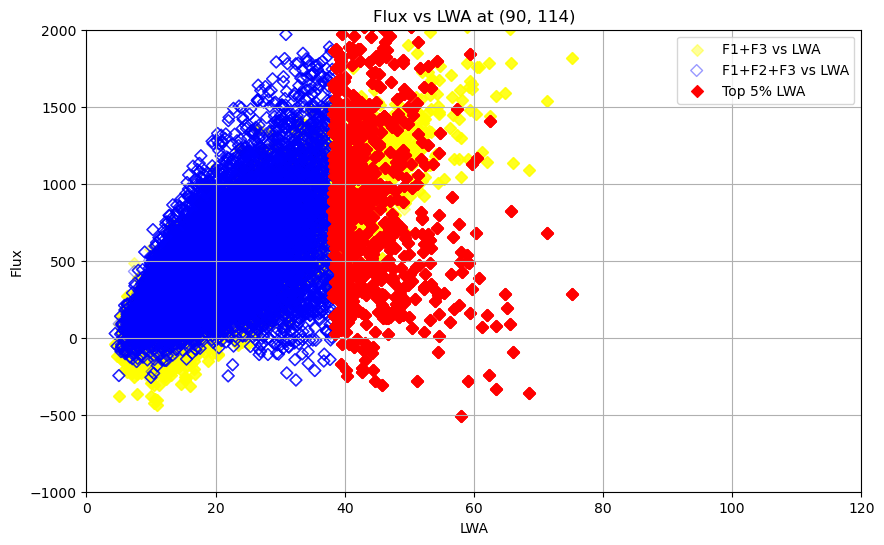

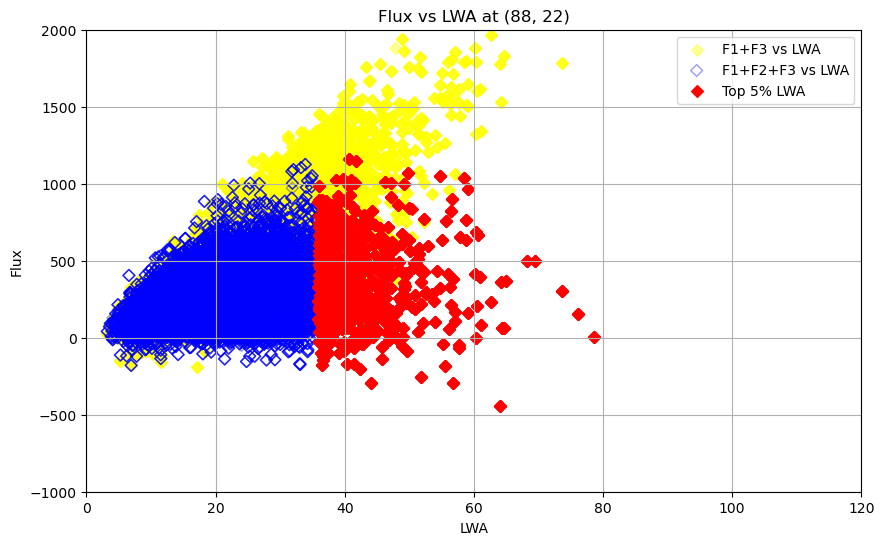

In [14]:
# 1-day avg

import os
import re
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

def load_data(directory):
    years = [year for year in range(1979, 2017)]
    date_pattern = re.compile(r'_(\d{4}_\d{2}_\d{2})_')

    def fetch_files(prefix):
        return sorted([f for f in os.listdir(directory) if f.startswith(prefix) and date_pattern.search(f)])

    def average_files(files):
        avg_data = []
        for file_group in tqdm(files, desc="Processing"):
            dates = list(set(date_pattern.findall(file_group)))
            for date in dates:
                date_files = [f for f in files if date in f]
                avg_data.append(np.mean([np.load(os.path.join(directory, file)) for file in date_files], axis=0))
        return avg_data

    files = {
        "LWA": fetch_files("column_LWA"),
        "F1": fetch_files("F1_"),
        "F2": fetch_files("F2_"),
        "F3": fetch_files("F3_"),
    }

    return {key: average_files(val) for key, val in files.items()}

def plot_scatter(data, idx):
    x_idx, y_idx = idx
    LWA_values = [data["LWA"][i][x_idx, y_idx] for i in range(len(data["LWA"]))]
    F_total_values = [data["F1"][i][x_idx, y_idx] + data["F2"][i][x_idx, y_idx] + data["F3"][i][x_idx, y_idx] for i in range(len(data["F1"]))]
    F13_values = [data["F1"][i][x_idx, y_idx] + data["F3"][i][x_idx, y_idx] for i in range(len(data["F1"]))]

    sorted_LWA = sorted(LWA_values)
    threshold = sorted_LWA[int(0.95 * len(sorted_LWA))]

    plt.figure(figsize=(10,6))
    # For F1 + F3 vs LWA
    plt.scatter(LWA_values, F13_values, color='yellow', marker='D', alpha=0.4, label='F1+F3 vs LWA')
    
    # For F1 + F2 + F3 vs LWA
    plt.scatter([val for val in LWA_values if val < threshold], 
                [F_total_values[i] for i, val in enumerate(LWA_values) if val < threshold], 
                facecolors='none', edgecolors='blue', marker='D', alpha=0.4, label='F1+F2+F3 vs LWA')
    
    plt.scatter([val for val in LWA_values if val >= threshold], 
                [F_total_values[i] for i, val in enumerate(LWA_values) if val >= threshold], 
                color='red', marker='D', label='Top 5% LWA')



    plt.xlabel('LWA')
    plt.ylabel('Flux')
    plt.title(f'Flux vs LWA at {idx}')
    plt.ylim(-1000, 2000)
    plt.xlim(0, 120)
    plt.grid(True)
    plt.legend()
    plt.show()

directory = "/scratch/negishi/yan481/KenYan_Traffic_Model/hn2016-falwa_calculation"
data = load_data(directory)
indices = [(90,114), (88, 22)]

for idx in indices:
    plot_scatter(data, idx)


Processing: 100%|██████████| 55064/55064 [20:55<00:00, 43.86it/s]


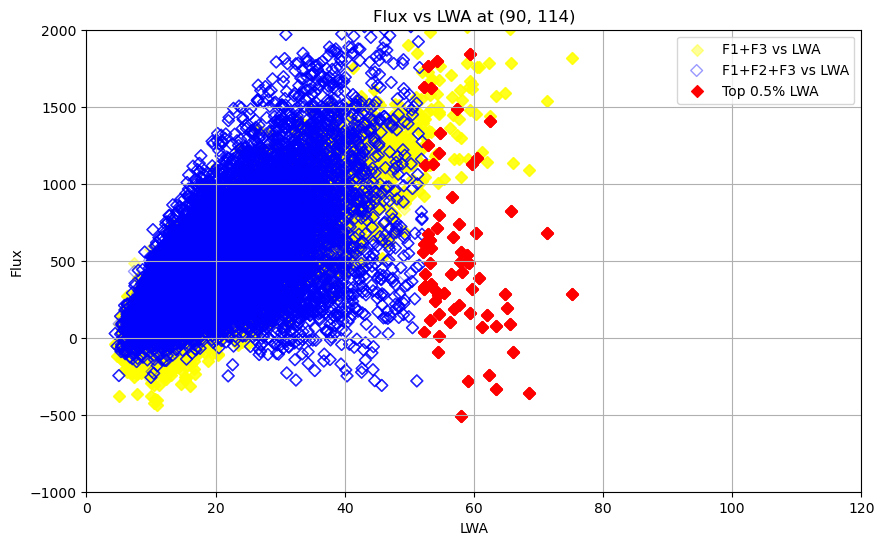

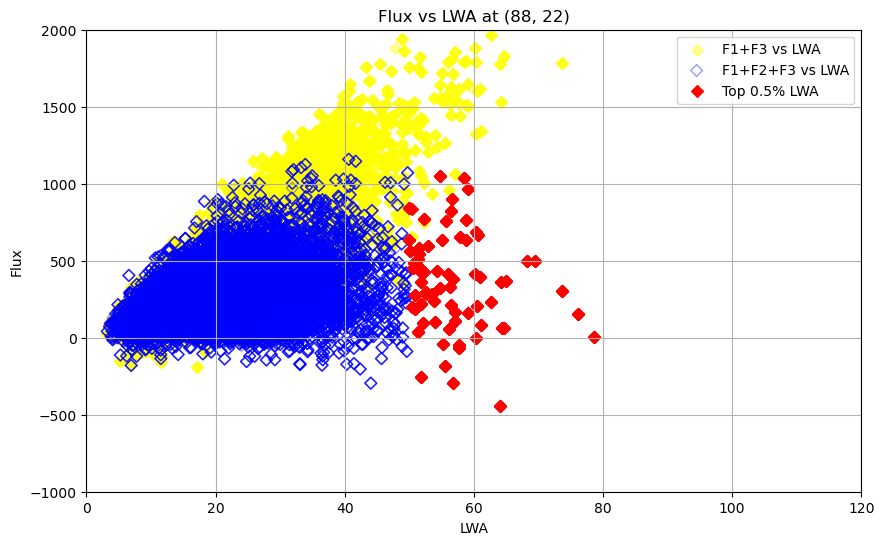

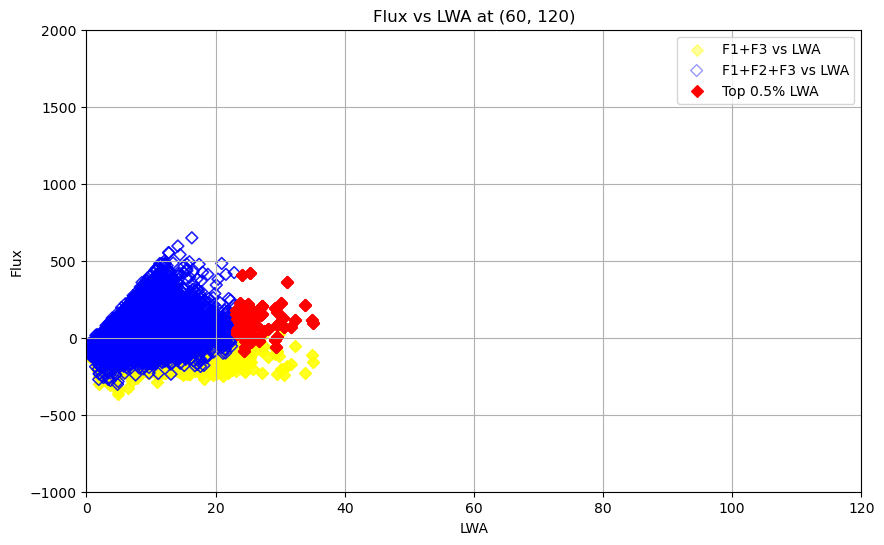

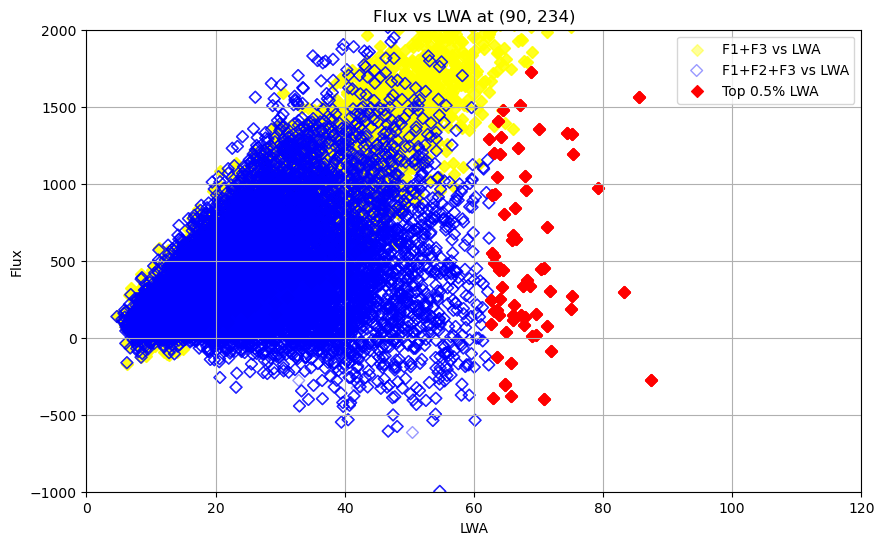

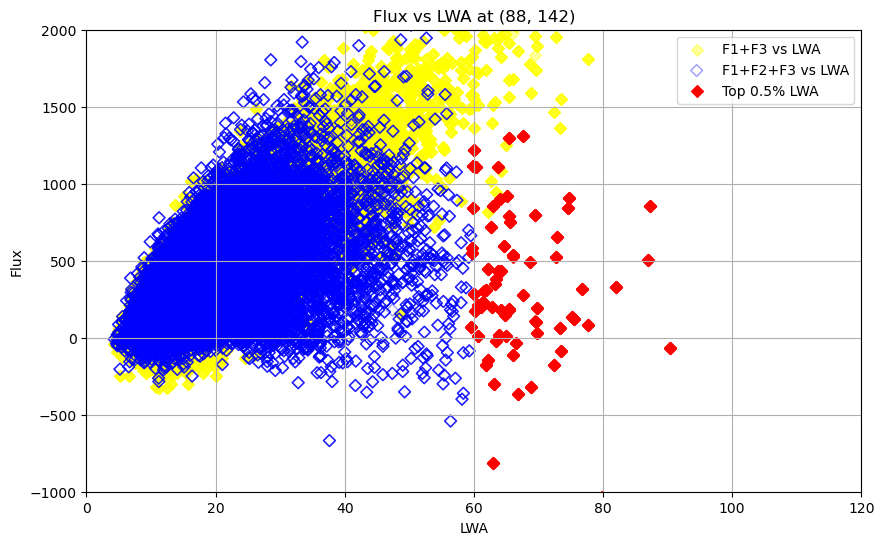

In [3]:
# 1-day avg

import os
import re
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

def load_data(directory):
    years = [year for year in range(1979, 2017)]
    date_pattern = re.compile(r'_(\d{4}_\d{2}_\d{2})_')

    def fetch_files(prefix):
        return sorted([f for f in os.listdir(directory) if f.startswith(prefix) and date_pattern.search(f)])

    def average_files(files):
        avg_data = []
        for file_group in tqdm(files, desc="Processing"):
            dates = list(set(date_pattern.findall(file_group)))
            for date in dates:
                date_files = [f for f in files if date in f]
                avg_data.append(np.mean([np.load(os.path.join(directory, file)) for file in date_files], axis=0))
        return avg_data

    files = {
        "LWA": fetch_files("column_LWA"),
        "F1": fetch_files("F1_"),
        "F2": fetch_files("F2_"),
        "F3": fetch_files("F3_"),
    }

    return {key: average_files(val) for key, val in files.items()}

def plot_scatter(data, idx):
    x_idx, y_idx = idx
    LWA_values = [data["LWA"][i][x_idx, y_idx] for i in range(len(data["LWA"]))]
    F_total_values = [data["F1"][i][x_idx, y_idx] + data["F2"][i][x_idx, y_idx] + data["F3"][i][x_idx, y_idx] for i in range(len(data["F1"]))]
    F13_values = [data["F1"][i][x_idx, y_idx] + data["F3"][i][x_idx, y_idx] for i in range(len(data["F1"]))]

    sorted_LWA = sorted(LWA_values)
    threshold = sorted_LWA[int(0.995 * len(sorted_LWA))]

    plt.figure(figsize=(10,6))
    # For F1 + F3 vs LWA
    plt.scatter(LWA_values, F13_values, color='yellow', marker='D', alpha=0.4, label='F1+F3 vs LWA')
    
    # For F1 + F2 + F3 vs LWA
    plt.scatter([val for val in LWA_values if val < threshold], 
                [F_total_values[i] for i, val in enumerate(LWA_values) if val < threshold], 
                facecolors='none', edgecolors='blue', marker='D', alpha=0.4, label='F1+F2+F3 vs LWA')
    
    plt.scatter([val for val in LWA_values if val >= threshold], 
                [F_total_values[i] for i, val in enumerate(LWA_values) if val >= threshold], 
                color='red', marker='D', label='Top 0.5% LWA')



    plt.xlabel('LWA')
    plt.ylabel('Flux')
    plt.title(f'Flux vs LWA at {idx}')
    plt.ylim(-1000, 2000)
    plt.xlim(0, 120)
    plt.grid(True)
    plt.legend()
    plt.show()

directory = "/scratch/negishi/yan481/KenYan_Traffic_Model/hn2016-falwa_calculation"
data = load_data(directory)
indices = [(90,114), (88, 22), (60,120),(90, 234),(88, 142)]


for idx in indices:
    plot_scatter(data, idx)


Processing: 100%|██████████| 55064/55064 [21:40<00:00, 42.36it/s]


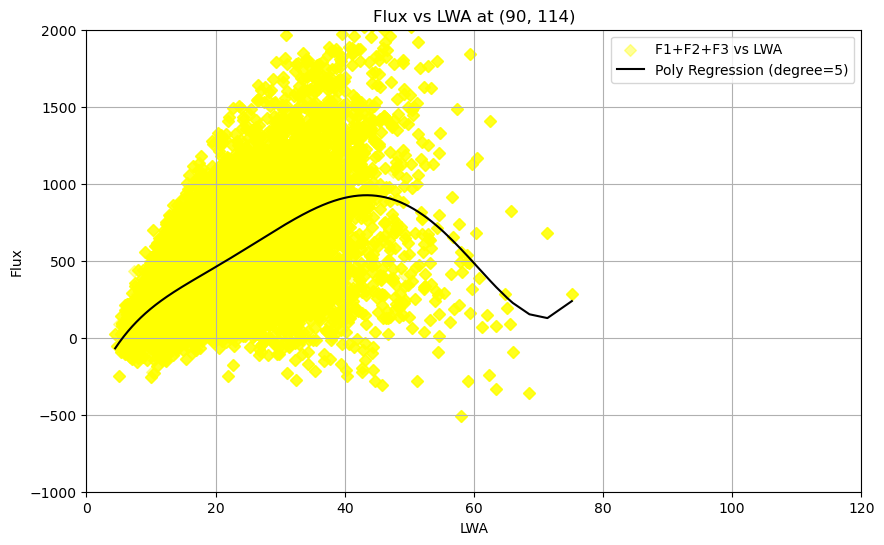

Best polynomial for idx (90, 114): y = -438.670 + 107.287x^1 + -6.410x^2 + 0.232x^3 + -0.004x^4 + 0.000x^5
Mean cross validation error (MSE): -71399.976


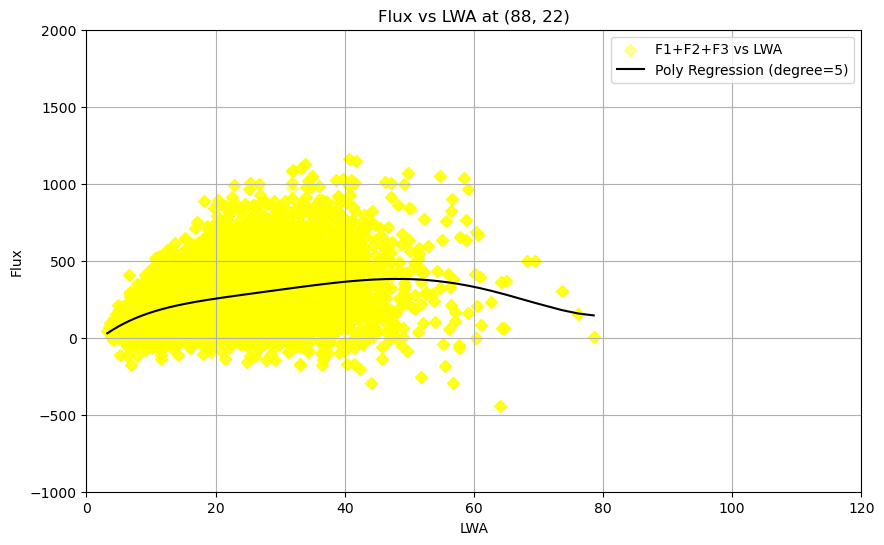

Best polynomial for idx (88, 22): y = -80.574 + 39.750x^1 + -2.040x^2 + 0.059x^3 + -0.001x^4 + 0.000x^5
Mean cross validation error (MSE): -21526.253


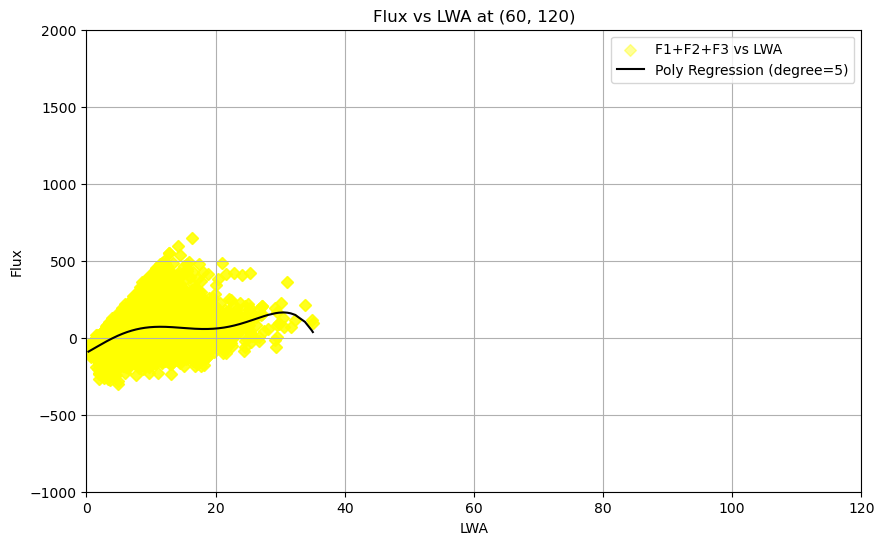

Best polynomial for idx (60, 120): y = -97.644 + 22.771x^1 + 1.084x^2 + -0.286x^3 + 0.014x^4 + -0.000x^5
Mean cross validation error (MSE): -7840.246


In [16]:
import os
import re
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import cross_val_score

def load_data(directory):
    years = [year for year in range(1979, 2017)]
    date_pattern = re.compile(r'_(\d{4}_\d{2}_\d{2})_')

    def fetch_files(prefix):
        return sorted([f for f in os.listdir(directory) if f.startswith(prefix) and date_pattern.search(f)])

    def average_files(files):
        avg_data = []
        for file_group in tqdm(files, desc="Processing"):
            dates = list(set(date_pattern.findall(file_group)))
            for date in dates:
                date_files = [f for f in files if date in f]
                avg_data.append(np.mean([np.load(os.path.join(directory, file)) for file in date_files], axis=0))
        return avg_data

    files = {
        "LWA": fetch_files("column_LWA"),
        "F1": fetch_files("F1_"),
        "F2": fetch_files("F2_"),
        "F3": fetch_files("F3_"),
    }

    return {key: average_files(val) for key, val in files.items()}

def polynomial_regression(X, y, degrees):
    """
    Perform polynomial regression and return the best model, its degree and the cross validation scores.
    """
    X = X.reshape(-1, 1)  # Reshape to be 2D

    best_score = float('-inf')
    best_degree = 0
    best_model = None

    for degree in degrees:
        poly = PolynomialFeatures(degree=degree)
        X_poly = poly.fit_transform(X)
        model = LinearRegression().fit(X_poly, y)

        # Cross validation
        scores = cross_val_score(model, X_poly, y, cv=5, scoring='neg_mean_squared_error')  # 5-fold CV
        mean_score = np.mean(scores)
        
        if mean_score > best_score:
            best_score = mean_score
            best_degree = degree
            best_model = model

    return best_model, best_degree, best_score

def plot_scatter(data, idx):
    x_idx, y_idx = idx
    LWA_values = np.array([data["LWA"][i][x_idx, y_idx] for i in range(len(data["LWA"]))])
    F_total_values = np.array([data["F1"][i][x_idx, y_idx] + data["F2"][i][x_idx, y_idx] + data["F3"][i][x_idx, y_idx] for i in range(len(data["F1"]))])

    # Polynomial regression
    best_model, best_degree, best_score = polynomial_regression(LWA_values, F_total_values, degrees=[1, 2, 3, 4, 5])
    poly = PolynomialFeatures(degree=best_degree)
    X_poly = poly.fit_transform(LWA_values.reshape(-1, 1))
    predictions = best_model.predict(X_poly)

    # Plot scatter
    plt.figure(figsize=(10,6))
    plt.scatter(LWA_values, F_total_values, color='yellow', marker='D', alpha=0.4, label='F1+F2+F3 vs LWA')
    # Plot regression line
    sorted_args = np.argsort(LWA_values)
    plt.plot(LWA_values[sorted_args], predictions[sorted_args], color='black', label=f'Poly Regression (degree={best_degree})')

    plt.xlabel('LWA')
    plt.ylabel('Flux')
    plt.title(f'Flux vs LWA at {idx}')
    plt.ylim(-1000, 2000)
    plt.xlim(0, 120)
    plt.grid(True)
    plt.legend()
    plt.show()

    # Print the polynomial and the error
    coefficients = best_model.coef_
    intercept = best_model.intercept_

    expression = f"y = {intercept:.3f}"
    for i, coef in enumerate(coefficients[1:], 1):
        expression += f" + {coef:.3f}x^{i}"
    print(f"Best polynomial for idx {idx}: {expression}")
    print(f"Mean cross validation error (MSE): {best_score:.3f}")

directory = "/scratch/negishi/yan481/KenYan_Traffic_Model/hn2016-falwa_calculation"
data = load_data(directory)
indices = [(90,114), (88, 22), (60,120)]

for idx in indices:
    plot_scatter(data, idx)


Processing: 100%|██████████| 55064/55064 [20:23<00:00, 45.00it/s]


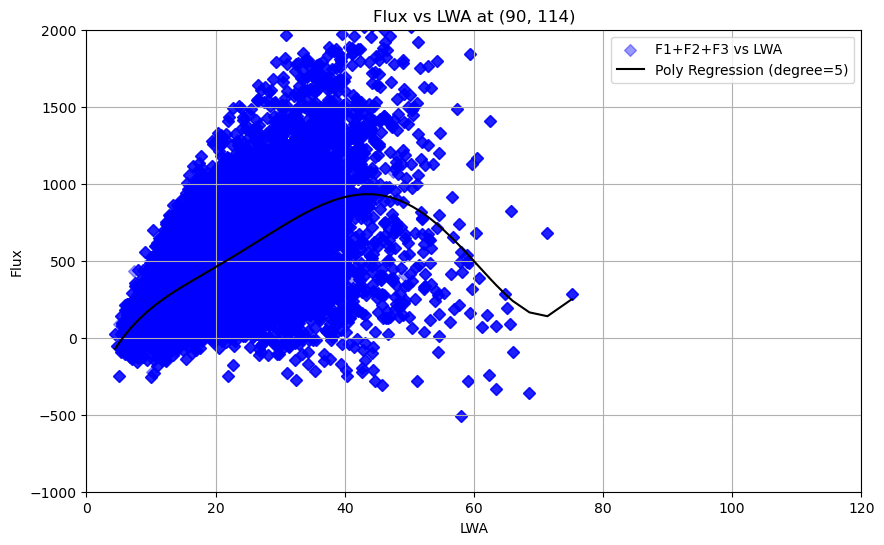

Best polynomial for idx (90, 114): y = -446.750 + 109.250x^1 + -6.569x^2 + 0.237x^3 + -0.004x^4 + 0.000x^5
Mean cross validation error (MSE): 71079.543


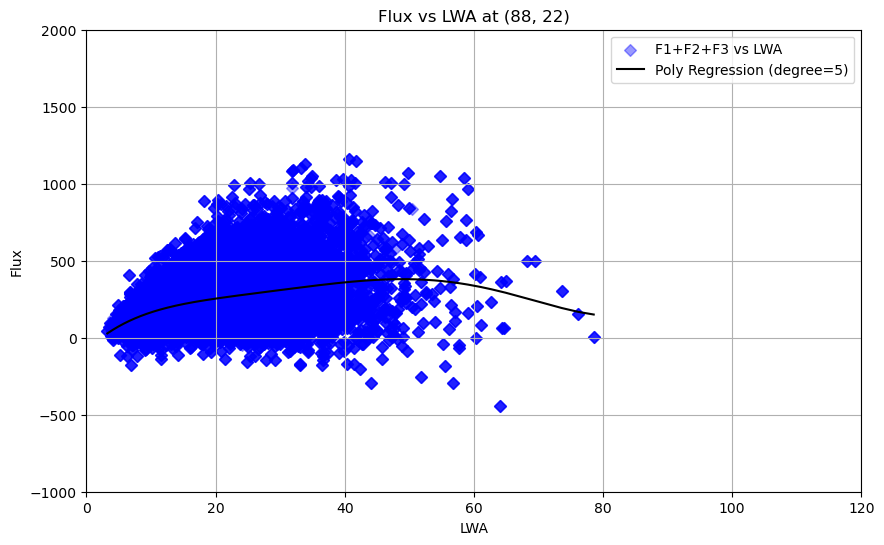

Best polynomial for idx (88, 22): y = -81.472 + 39.761x^1 + -2.011x^2 + 0.057x^3 + -0.001x^4 + 0.000x^5
Mean cross validation error (MSE): 21293.291


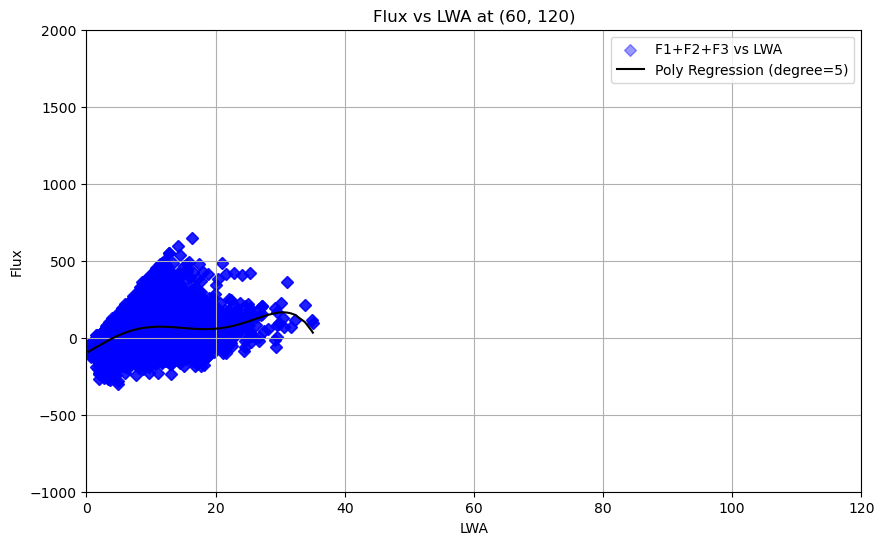

Best polynomial for idx (60, 120): y = -98.007 + 22.591x^1 + 1.186x^2 + -0.298x^3 + 0.014x^4 + -0.000x^5
Mean cross validation error (MSE): 7862.982


NameError: name 'best_score' is not defined

In [17]:
import os
import re
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import cross_val_score

def load_data(directory):
    years = [year for year in range(1979, 2017)]
    date_pattern = re.compile(r'_(\d{4}_\d{2}_\d{2})_')

    def fetch_files(prefix):
        return sorted([f for f in os.listdir(directory) if f.startswith(prefix) and date_pattern.search(f)])

    def average_files(files):
        avg_data = []
        for file_group in tqdm(files, desc="Processing"):
            dates = list(set(date_pattern.findall(file_group)))
            for date in dates:
                date_files = [f for f in files if date in f]
                avg_data.append(np.mean([np.load(os.path.join(directory, file)) for file in date_files], axis=0))
        return avg_data

    files = {
        "LWA": fetch_files("column_LWA"),
        "F1": fetch_files("F1_"),
        "F2": fetch_files("F2_"),
        "F3": fetch_files("F3_"),
    }

    return {key: average_files(val) for key, val in files.items()}

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

def polynomial_regression(X, y, degrees):
    """
    Perform polynomial regression and return the best model, its degree, and the test error.
    """
    X = X.reshape(-1, 1)  # Reshape to be 2D

    best_error = float('inf')
    best_degree = 0
    best_model = None

    # Split the data into training and testing sets (80:20)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

    for degree in degrees:
        poly = PolynomialFeatures(degree=degree)
        X_train_poly = poly.fit_transform(X_train)
        X_test_poly = poly.transform(X_test)
        
        model = LinearRegression().fit(X_train_poly, y_train)

        # Predictions for test data
        y_pred = model.predict(X_test_poly)
        error = mean_squared_error(y_test, y_pred)
        
        if error < best_error:
            best_error = error
            best_degree = degree
            best_model = model

    return best_model, best_degree, best_error


def plot_scatter(data, idx):
    x_idx, y_idx = idx
    LWA_values = np.array([data["LWA"][i][x_idx, y_idx] for i in range(len(data["LWA"]))])
    F_total_values = np.array([data["F1"][i][x_idx, y_idx] + data["F2"][i][x_idx, y_idx] + data["F3"][i][x_idx, y_idx] for i in range(len(data["F1"]))])

    # Polynomial regression
    best_model, best_degree, best_score = polynomial_regression(LWA_values, F_total_values, degrees=[1, 2, 3, 4, 5])
    poly = PolynomialFeatures(degree=best_degree)
    X_poly = poly.fit_transform(LWA_values.reshape(-1, 1))
    predictions = best_model.predict(X_poly)

    # Plot scatter
    plt.figure(figsize=(10,6))
    plt.scatter(LWA_values, F_total_values, color='blue', marker='D', alpha=0.4, label='F1+F2+F3 vs LWA')
    # Plot regression line
    sorted_args = np.argsort(LWA_values)
    plt.plot(LWA_values[sorted_args], predictions[sorted_args], color='black', label=f'Poly Regression (degree={best_degree})')

    plt.xlabel('LWA')
    plt.ylabel('Flux')
    plt.title(f'Flux vs LWA at {idx}')
    plt.ylim(-1000, 2000)
    plt.xlim(0, 120)
    plt.grid(True)
    plt.legend()
    plt.show()

    # Print the polynomial and the error
    coefficients = best_model.coef_
    intercept = best_model.intercept_

    expression = f"y = {intercept:.3f}"
    for i, coef in enumerate(coefficients[1:], 1):
        expression += f" + {coef:.3f}x^{i}"
    print(f"Best polynomial for idx {idx}: {expression}")
    print(f"Mean cross validation error (MSE): {best_score:.3f}")

directory = "/scratch/negishi/yan481/KenYan_Traffic_Model/hn2016-falwa_calculation"
data = load_data(directory)
indices = [(90,114), (88, 22), (60,120)]

for idx in indices:
    plot_scatter(data, idx)  # The plot_scatter function uses the modified polynomial_regression

